In [1]:
# !pip install chart_studio

In [2]:
import os 
import random 
from random import sample, choice
from datetime import date, datetime
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd
from collections import defaultdict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

from pytorch_metric_learning.losses import ContrastiveLoss

In [3]:
from src.datasets.data import SPReader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import *

from src.utils.analysis import action_evaluator

In [4]:
from sklearn.manifold import TSNE
from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [5]:
# import chart_studio
# import chart_studio.plotly as py 
# import chart_studio.tools as tls

# plotly_user = 'nipdep'
# plotly_key = 'BNQUTzoP5YBLtc8uggat'
# chart_studio.tools.set_credentials_file(username=plotly_user, api_key=plotly_key)

In [66]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    
    "sem-space": 'attr',
    # model training configs
    "model_params":{
        "linear_filters":[512,1024,1024,256],
        "input_feat":36,
        "dropout":0.1,
    },
    "include_attribute_loss": True, 
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.9,
    "imu_alpha": 0.7,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 256, # skel-AE hidden size and IMU-Anc output size
    "semantic_size": 64,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [7]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048],input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [8]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

In [9]:
torch.isnan(model(torch.rand((32, 36)))).sum()

tensor(0)

---

In [10]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)
              
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        return x

class SkeletonAE(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(SkeletonAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [11]:
ae_model = SkeletonAE(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=128, num_layers=1,bidirectional=True,batch_size=32)
prep_dir = './data/Pre-trained Skeleton models/PAMAP2/epoch100_emb128.pt'
ae_model.load_state_dict(torch.load(prep_dir)["model_state_dict"])

<All keys matched successfully>

---

In [12]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = SPReader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:1087: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [14]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [15]:
skeleton_data = np.load('./data/skeleton_k10_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [16]:
skeleton_mov.shape

(180, 60, 36)

In [17]:
np.unique(skeleton_classes, return_counts=True)

(array(['Nordic walking', 'ascending stairs', 'car driving',
        'computer work', 'cycling', 'descending stairs', 'folding laundry',
        'house cleaning', 'ironing', 'lying', 'playing soccer',
        'rope jumping', 'running', 'sitting', 'standing',
        'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10], dtype=int64))

In [18]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [19]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [20]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [21]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [22]:
def get_class_ft(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    with torch.no_grad():
        _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    return action_feat_mat

---

In [23]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) # self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [24]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 36])


In [25]:
data_dict['train']['X'].shape[0] + data_dict['eval-seen']['X'].shape[0] + data_dict['test']['X'].shape[0]

26549

In [26]:
data_dict['seen_classes']

[0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]

In [27]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [28]:
[random.choice(action_dict[i]) for i in data_dict['seen_classes']]

[80, 134, 168, 127, 30, 95, 27, 13, 48, 155, 73, 52, 101, 117]

In [29]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [30]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [31]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [32]:
# r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
# r_out1.shape, r_out2.shape

---

In [33]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = torch.from_numpy(movements[:, :seq_len, ...])
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())  

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]
        # partial_idx = random.sample(self.action_dict[action], k=1)[0]
        # x2 = self.movements[partial_idx, ...]
        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape

    def get_actions(self, label):
        return self.movements[self.action_dict[label], ...]


In [34]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [35]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 50, 36])


In [36]:
sample_dt.getShape()

torch.Size([50, 36])

---

In [64]:
class ActionTripletLoss(nn.Module):
    # def __init__(self, action_feats, label_map, pos_thr=0.05, neg_thr=0.95, agg="mean"):
    def __init__(self, action_feats, label_map, distance='cosine', k=10, pos_thr=0.05, neg_thr=0.95, theta=1e-4, agg="mean", device="cpu"):
        super(ActionTripletLoss, self).__init__()
        self.action_feats = deepcopy(action_feats)
        self.label_map = label_map
        self.distance = distance
        self.get_disMet(distance)
        self.k = k
        self.pos_thr = pos_thr
        self.neg_thr = neg_thr
        self.agg = agg 
        self.theta = theta
        self.device = device 

    def get_disMet(self, distance):
        if distance == 'cosine':
            self.disMet = nn.CosineSimilarity(dim=1, eps=1e-6)
        else:
            self.disMet = nn.PairwiseDistance(p=2)

    def positive_sampling(self, label, k=10):
        total_samples = self.action_feats[label]
        self.n, _ = total_samples.shape 
        sample_idx = sample(range(self.n), k)
        samples = total_samples[sample_idx, :]
        return torch.from_numpy(samples).to(device)

    def negative_sampling(self, label, k=10):
        neg_action = set(self.action_feats.keys())-{label}
        neg_sample_action = sample(neg_action, k)
        sample_point = choice(range(self.n)) # has to change
        neg_samples = np.array([self.action_feats[a][sample_point, :] for a in neg_sample_action])
        neg_samples = torch.from_numpy(neg_samples)
        return neg_samples.to(device)

    def positive_distance(self, pred_vector, pos_vectors, agg='mean'):
        pos_distances = self.disMet(pred_vector, pos_vectors).to(self.device)
        if self.distance == 'cosine':
            pos_distances = 1. - torch.abs(pos_distances)
        soft_distance = F.relu(torch.sub(torch.abs(pos_distances),Tensor([self.pos_thr]).to(self.device)))
        if agg == "mean":
            return pos_distances.mean()
        else:
            return pos_distances.sum()

    def negative_distance(self, pred_vector, neg_vectors, agg="mean"):
        neg_distances = self.disMet(pred_vector, neg_vectors).to(self.device)
        if self.distance == 'cosine':
            neg_distances = 1. - torch.abs(neg_distances)
        soft_distance = F.relu(torch.sub(Tensor([self.neg_thr]).to(self.device),torch.abs(neg_distances)))
        if agg == "mean":
            return neg_distances.mean()
        else:
            return neg_distances.sum()

    def forward(self, pred_fts, labels):
        pos_loss, neg_loss = 0, 0
        labels = torch.squeeze(labels).cpu().numpy().tolist()
        # print(labels)
        for i,l in enumerate(labels):
            l = self.label_map[l]
            ft = pred_fts[i, ...]
            pos_vectors = self.positive_sampling(l, self.k)
            neg_vectors = self.negative_sampling(l, self.k)
            pos_loss += self.positive_distance(ft, pos_vectors, agg=self.agg)
            neg_loss += self.negative_distance(ft, neg_vectors, agg=self.agg)

        pos_loss = pos_loss/len(labels)
        neg_loss = neg_loss/len(labels)
        return F.relu(pos_loss-neg_loss+self.theta)


In [61]:
class DistanceCCELoss(nn.Module):
    # def __init__(self, action_feats, label_map, pos_thr=0.05, neg_thr=0.95, agg="mean"):
    def __init__(self, action_feats, label_map, distance='cosine', k=10, pos_thr=0.05, neg_thr=0.95, agg="mean", device="cpu"):
        super(DistanceCCELoss, self).__init__()
        self.action_feats = deepcopy(action_feats)
        self.label_map = label_map
        self.distance = distance
        self.device = device 
        self.get_disMet(distance)
        self.avg_vector(action_feats)
        self.k = k
        self.pos_thr = pos_thr
        self.neg_thr = neg_thr
        self.agg = agg 
        
        self.cceLoss = nn.CrossEntropyLoss()

    def get_disMet(self, distance):
        if distance == 'cosine':
            self.disMet = nn.CosineSimilarity(dim=-1, eps=1e-6)
        else:
            self.disMet = nn.PairwiseDistance(p=2)

    def avg_vector(self, action_feats):
        avg_feats = {i: v.mean(axis=0) for i,v in action_feats.items()}
        keys = list(avg_feats.keys())
        keys.sort()
        self.ref_mat = torch.Tensor(np.array([avg_feats[i] for i in keys])).to(self.device)
        # self.ref_mat.unsqueeze_(1)

    def forward(self, pred_fts, y):
        # print(pred_fts.shape, self.ref_mat.shape)
        pred_fts = torch.unsqueeze(pred_fts, 1)
        dist = self.disMet(pred_fts, self.ref_mat)
        if self.distance == 'l2':
            dist = 1. - dist 
        elif self.distance == 'cosine':
            dist = torch.abs(dist)

        # print(dist.shape)
        cce_loss = self.cceLoss(dist, y)
        pred_y = torch.argmax(dist, dim=-1)
        return cce_loss, pred_y

---

In [39]:
def get_class_avg(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    avg_vector = np.mean(action_feat_mat, axis=0)
    # print(action_feat_mat.shape, avg_vector.shape)
    return avg_vector

In [40]:
def imu_train_step1(model, ae, dataloader, skel_dt, optimizer, loss_module, device, class_names, class_ids, phase='train', l2_reg=False, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    epoch_acc = 0

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, _, padding_masks = batch
            X = X.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
            
            # print(feat_output.shape, targets.shape)
            # print('feat_output : ', torch.isnan(feat_output).sum(), 'input feat : ', torch.isnan(X).sum())
            class_loss, pred_class = loss_module['class'](feat_output, targets.squeeze())
            # print(class_loss)
            feat_loss = loss_module['feature'](feat_output, targets)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss
            # loss = class_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            # print(class_output.shape)
            pred_class = pred_class.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            epoch_acc += metrics["accuracy"]
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / len(dataloader)  # average loss per sample for whole epoch
    epoch_acc = epoch_acc / len(dataloader)
    return {'loss': epoch_loss, 'accuracy': epoch_acc}

In [41]:
def ae_train_step1(model, dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    const_loss = 0 
    recons_loss = 0
    epoch_loss = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            xa, labels = batch 
            # post-process 
            # xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            # f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            # cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](ft_output, labels)()
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            # total_loss = con_loss #
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    const_loss += con_loss.item()    
                    recons_loss += l2_loss.item()
                    epoch_loss += total_loss.item()
            tepoch.set_postfix(metrics)

    m = len(dataloader)
    epoch_metrics = {'total_loss': epoch_loss/m, 'contrastive_loss': const_loss/m, 'reconstruction_loss':recons_loss/m}
    return epoch_metrics

In [42]:
def plot_umap(X, y, Id2Label):
    umap_2d = UMAP(n_components=2, random_state=43)
    cmp_data = umap_2d.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800, title="UMAP")
    fig.show()

In [43]:
def plot_tnse(X, y, Id2Label):
    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    cmp_data = tnse.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800, title='t-SNE')
    fig.show()
    return fig

In [44]:
def get_action_vector(ae, skel_dt, device, class_ids, class_names, batch_size=32):
    # generate unseen action_semantic from unseen skeleton seq. 
    label_dict = {c:i for i,c in enumerate(class_ids)}
    all_actions = []
    all_labels = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        ns, _, _ = action_mat.shape 
        class_labels = [label_dict[c] for _ in range(ns)]
        padded_mat = F.pad(input=action_mat, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
        _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
        action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

        all_actions.append(action_feat_mat)
        all_labels.append(class_labels)

    all_actions = np.concatenate(all_actions)
    all_labels = np.concatenate(all_labels)
    Id2Label = {i:l for i,l in enumerate(class_names)}
    return all_actions, all_labels, Id2Label


In [45]:
def eval_step1(model, dataloader, sem_actions, sem_labels, loss_module, device, class_names, class_ids, target_feat_met, phase='seen', l2_reg=False, print_report=True, show_plot=True, loss_alpha=0.7, batch_size=32, neighs=5):
    model = model.train()
    
    label_dict = {c:i for i,c in enumerate(class_ids)}
    inv_label_dict = {i:c for i,c in enumerate(class_ids)}
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'pred_feat': []}

    all_actions = sem_actions
    all_labels = np.array([label_dict[c] for c in sem_labels])
    # build knn model on know unseen samples 
    knn = KNeighborsClassifier(n_neighbors=neighs)
    knn.fit(all_actions, all_labels)
    # plot t-SNE on unseen vector 
    Id2Label = {i:l for i,l in enumerate(class_names)}
    # plot_tnse(all_actions, all_labels, Id2Label)
    # plot_umap(all_actions, all_labels, Id2Label)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)

            # with torch.set_grad_enabled(False):
            #     _, target_feat = ae(target_feat) # batch second mode
            
            if phase == 'seen':
                class_loss, class_output = loss_module['class'](feat_output, targets.squeeze())
            else:
                class_loss = 0 # 
            feat_loss = loss_module['feature'](feat_output, targets)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            with torch.no_grad():
                epoch_loss += loss.item()  # add total loss of batch
            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = class_output.cpu().detach().numpy()
            else:
                # print("targets > ", targets)
                # print("feat output", feat_output.shape)
                feat_numpy = feat_output.cpu().detach().numpy()
                pred_action = knn.predict(feat_numpy)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['pred_feat'].append(feat_output.cpu().detach().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    all_pred_actions = np.concatenate(per_batch["pred_feat"])
    # print("predictions > ", all_preds, "ground truth > ", all_targets[:, 0])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict['loss'] = epoch_loss/len(dataloader)
    all_targets = np.array([inv_label_dict[c] for c in all_targets.squeeze()])
    return metrics_dict, all_pred_actions, all_targets

---

Initiate Skeleton dataset ... 


train: 100%|██████████| 5/5 [00:01<00:00,  3.73batch/s, contrastive loss =0.226, reconstruction loss=0.0229]


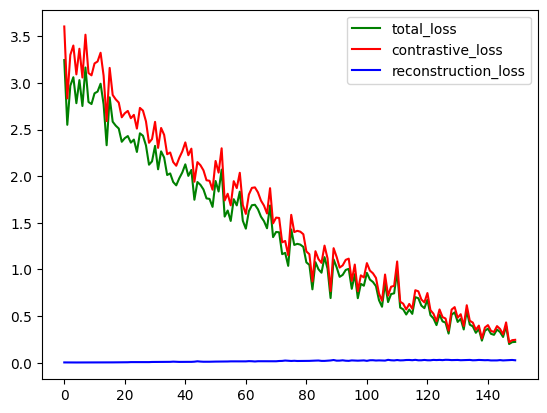

In [46]:
print("Initiate Skeleton dataset ... ")
# prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'
prep_dir = './data/Pre-trained Skeleton models/PAMAP2/epoch100_emb256.pt'

# build Skeleton dataset 
skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
skel_dl = DataLoader(skel_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
skel_n, skel_fts = skel_dt.getShape()

# build AE Model 
# ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
ae_config = {
    'seq_len':skel_n, 
    'input_size':skel_fts, 
    'hidden_size':512, 
    'linear_filters':[128,256,512], 
    'embedding_size':config['feat_size'], 
    'num_layers':1, 
    'bidirectional':True, 
    'batch_size':config['batch_size']
}
ae_model = SkeletonAE(device=device, **ae_config)
# ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
ae_model.load_state_dict(torch.load(prep_dir))
ae_model.to(device)

# define AE run parameters 
ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
ae_loss_module = {'contrast': SoftNearestNeighbours, 'recons': nn.MSELoss()}

ae_train_data = []
for epoch in tqdm(range(150), desc='Training Epoch', leave=False):
    # train AE model 
    ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
    ae_train_metrics['epoch'] = epoch
    ae_train_data.append(ae_train_metrics)

ae_train_df = pd.DataFrame().from_records(ae_train_data)

# plot train metrics 
fig, ax = plt.subplots()

ax.plot(ae_train_df['total_loss'], color = 'green', label = 'total_loss')
ax.plot(ae_train_df['contrastive_loss'], color = 'red', label = 'contrastive_loss')
ax.plot(ae_train_df['reconstruction_loss'], color = 'blue', label = 'reconstruction_loss')
ax.legend(loc = 'upper right')
plt.show()

# save transfer learned AE model weights 
t = datetime.now().strftime("%Y_%m_%d_%H_%M")
ae_trans_dir = f'./tmp/pamap2/ae_model_transfer_{t}.pt'
torch.save({
    'model_state_dict': ae_model.state_dict(),
    'config': ae_config
}, ae_trans_dir)

In [47]:
val_actions, val_labels, val_lm = get_action_vector(ae_model, skel_dt, device, class_ids=range(18), class_names=dataReader.idToLabel)
tsne_skel_plot = plot_tnse(val_actions, val_labels, val_lm)
plot_umap(val_actions, val_labels, val_lm)

In [48]:
# py.plot(tsne_skel_plot, filename='TSNE_Skeleton_plot', auto_open=False)

In [49]:
def plot_accVloss(train_data, val_data):
    train_sdf = pd.DataFrame.from_records(train_data)
    val_sdf = pd.DataFrame.from_records(val_data)

    train_sdf['phase'] = 'train'
    val_sdf['phase'] = 'validation'

    all_sdf = pd.concat([train_sdf, val_sdf.loc[:, ['loss', 'accuracy', 'phase']]], axis=0)
    all_sdf = all_sdf.rename_axis('epoch').reset_index()


    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(all_sdf, ax=axes[0], x='epoch', y='loss', hue='phase')
    sns.lineplot(all_sdf, ax=axes[1], x='epoch', y='accuracy', hue='phase')

In [50]:
def gen_semantic_space(ft_dict):
    action_ft = np.concatenate(list(ft_dict.values()), axis=0)

    action_label = []
    for i, k in enumerate(ft_dict.keys()):
        action_label.extend([k,]*ft_dict[k].shape[0])

    action_label = np.array(action_label)
    return action_ft, action_label

In [51]:
def over_plot_preds(gt_actions, gt_labels, pred_actions, pred_labels, Id2Label):
    gt_n = gt_actions.shape[0]
    pred_n = pred_actions.shape[0]

    all_actions = np.concatenate([gt_actions, pred_actions])
    all_labels = np.concatenate([gt_labels, pred_labels])
    all_types = ['GT',]*gt_n + ['pred',]*pred_n

    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    gt_data = tnse.fit_transform(all_actions)

    gt_df = pd.DataFrame(data=gt_data, columns=['x', 'y'])
    gt_df['label'] = all_labels 
    gt_df['action'] = gt_df['label'].map(val_lm)
    gt_df['type'] = all_types

    fig = px.scatter(gt_df, x='x', y='y', color='action', symbol='type', width=800, height=800, title='t-SNE')
    fig.show()

---

================ Fold-0 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


seen: 100%|██████████| 130/130 [00:07<00:00, 17.06batch/s, loss=1.68]


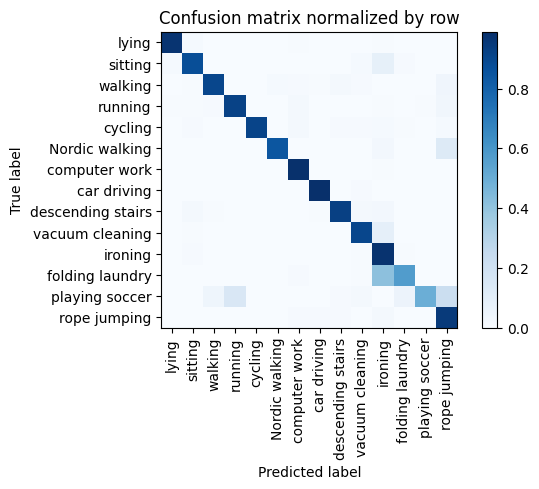

Training Epoch:   7%|▋         | 1/15 [01:02<14:31, 62.25s/it]

Overall accuracy: 0.905



seen: 100%|██████████| 130/130 [00:07<00:00, 17.38batch/s, loss=1.68]


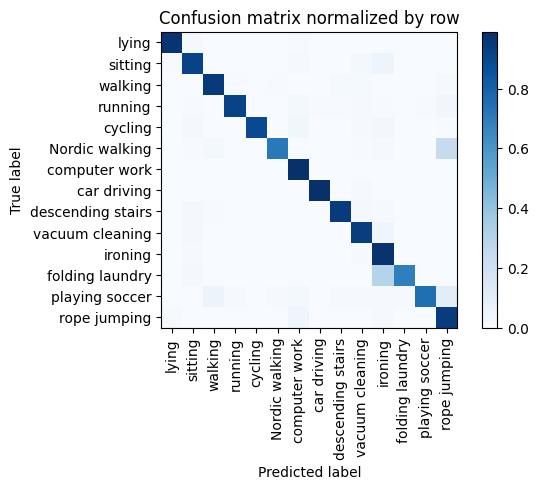

Training Epoch:  13%|█▎        | 2/15 [01:59<12:53, 59.51s/it]

Overall accuracy: 0.916



seen: 100%|██████████| 130/130 [00:08<00:00, 16.18batch/s, loss=1.68]


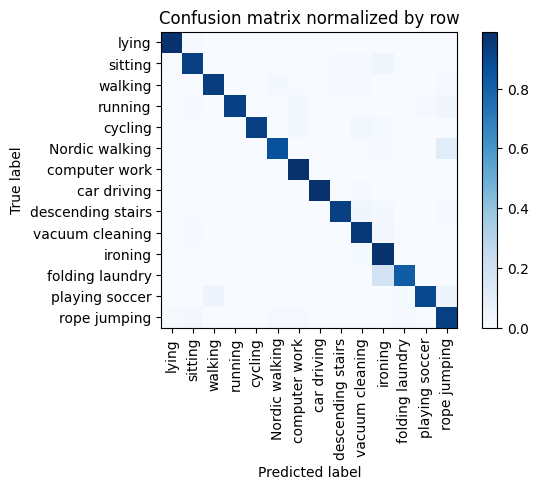

Training Epoch:  20%|██        | 3/15 [02:59<11:52, 59.41s/it]

Overall accuracy: 0.941



seen: 100%|██████████| 130/130 [00:07<00:00, 17.28batch/s, loss=1.67]


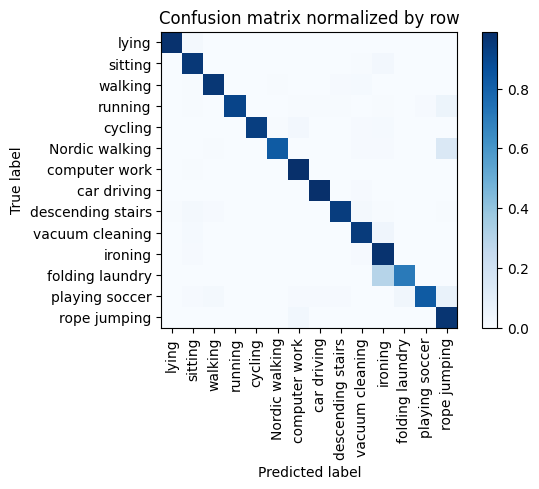

Training Epoch:  27%|██▋       | 4/15 [03:59<10:57, 59.78s/it]

Overall accuracy: 0.938



seen: 100%|██████████| 130/130 [00:07<00:00, 18.25batch/s, loss=1.67]


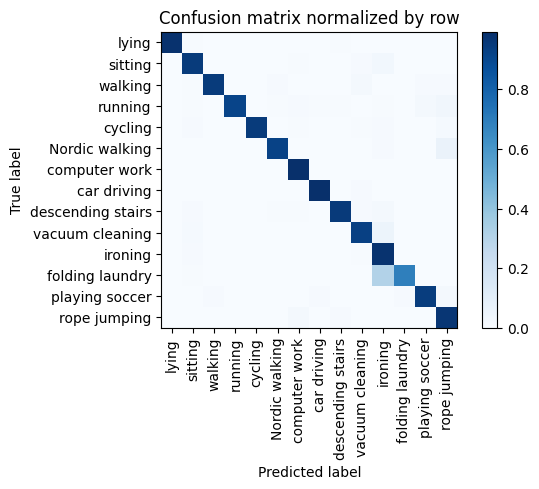

Training Epoch:  33%|███▎      | 5/15 [04:54<09:40, 58.04s/it]

Overall accuracy: 0.946



seen: 100%|██████████| 130/130 [00:07<00:00, 18.18batch/s, loss=1.68]


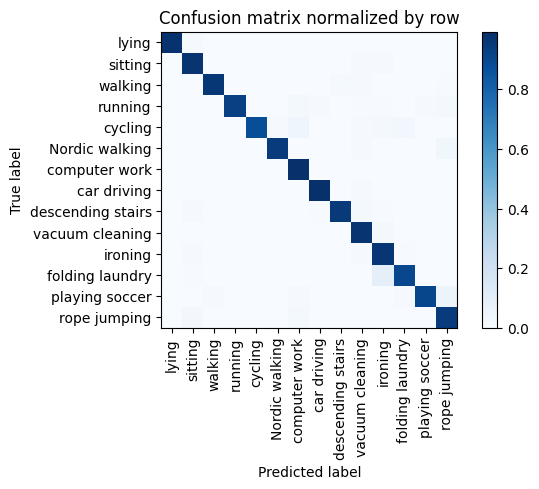

Training Epoch:  40%|████      | 6/15 [05:48<08:29, 56.66s/it]

Overall accuracy: 0.959



seen: 100%|██████████| 130/130 [00:06<00:00, 18.74batch/s, loss=1.68]


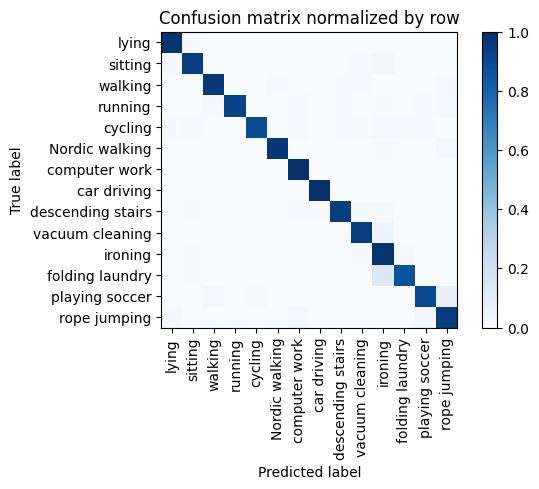

Training Epoch:  47%|████▋     | 7/15 [06:42<07:25, 55.73s/it]

Overall accuracy: 0.955



seen: 100%|██████████| 130/130 [00:06<00:00, 18.68batch/s, loss=1.69]


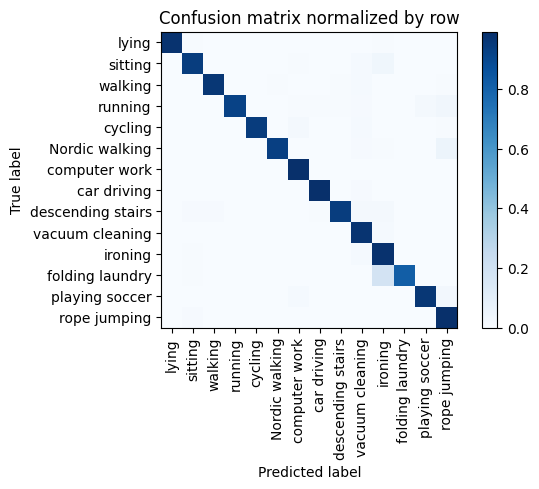

Training Epoch:  53%|█████▎    | 8/15 [07:35<06:24, 54.91s/it]

Overall accuracy: 0.958



seen: 100%|██████████| 130/130 [00:07<00:00, 18.32batch/s, loss=1.68]


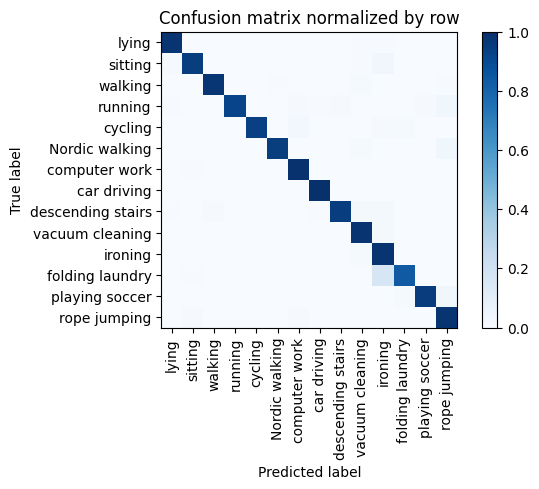

Training Epoch:  60%|██████    | 9/15 [08:29<05:28, 54.70s/it]

Overall accuracy: 0.961



seen: 100%|██████████| 130/130 [00:07<00:00, 16.97batch/s, loss=1.68]


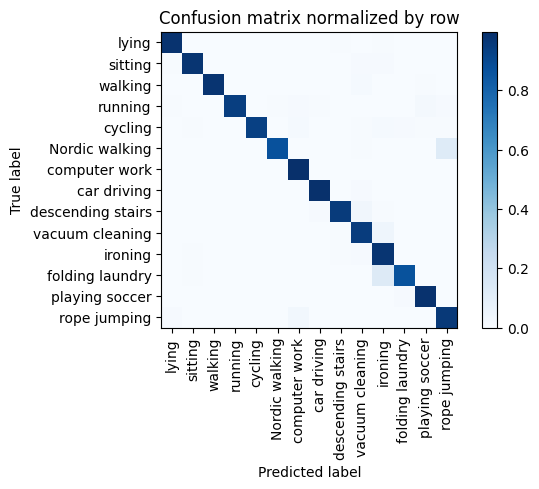

Training Epoch:  67%|██████▋   | 10/15 [09:25<04:34, 54.93s/it]

Overall accuracy: 0.958



seen: 100%|██████████| 130/130 [00:07<00:00, 17.65batch/s, loss=1.7]


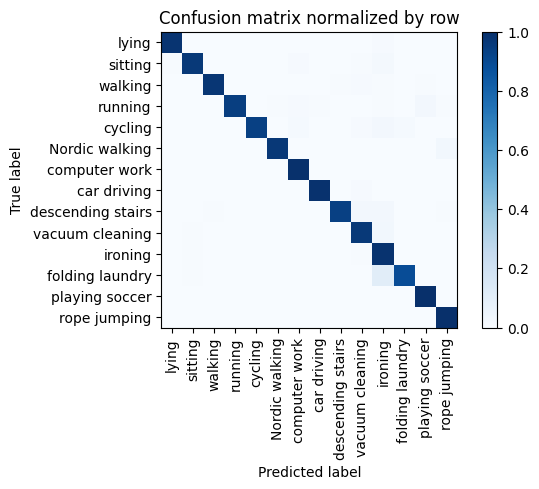

Training Epoch:  73%|███████▎  | 11/15 [10:24<03:45, 56.26s/it]

Overall accuracy: 0.969



seen: 100%|██████████| 130/130 [00:08<00:00, 16.06batch/s, loss=1.68]


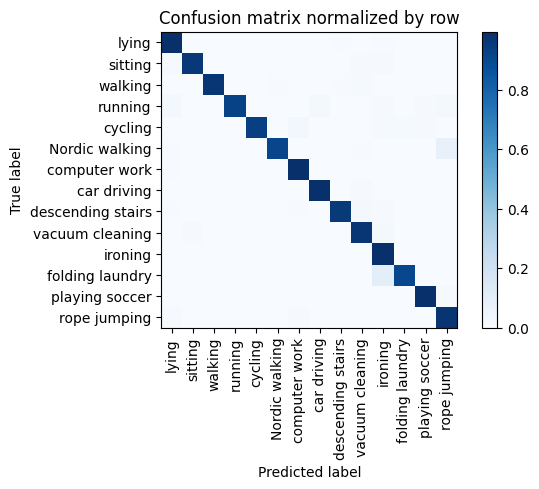

Training Epoch:  80%|████████  | 12/15 [11:22<02:50, 56.94s/it]

Overall accuracy: 0.965



seen: 100%|██████████| 130/130 [00:08<00:00, 15.94batch/s, loss=1.69]


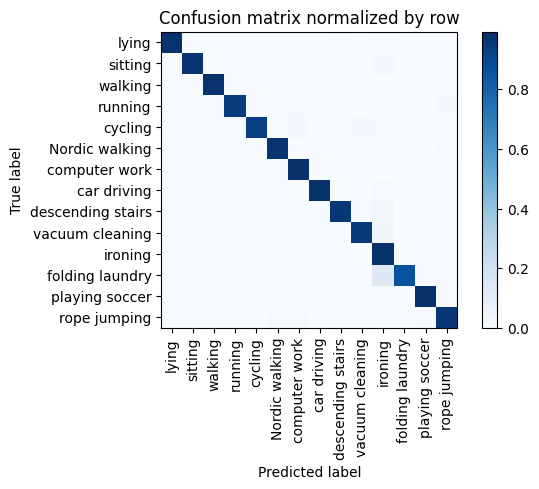

Training Epoch:  87%|████████▋ | 13/15 [12:28<01:59, 59.50s/it]

Overall accuracy: 0.970



seen: 100%|██████████| 130/130 [00:08<00:00, 15.55batch/s, loss=1.68]


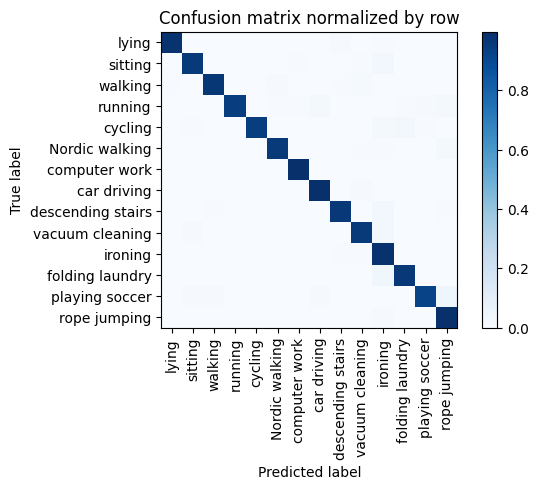

Training Epoch:  93%|█████████▎| 14/15 [13:32<01:00, 60.86s/it]

Overall accuracy: 0.970



seen: 100%|██████████| 130/130 [00:08<00:00, 15.52batch/s, loss=1.68]


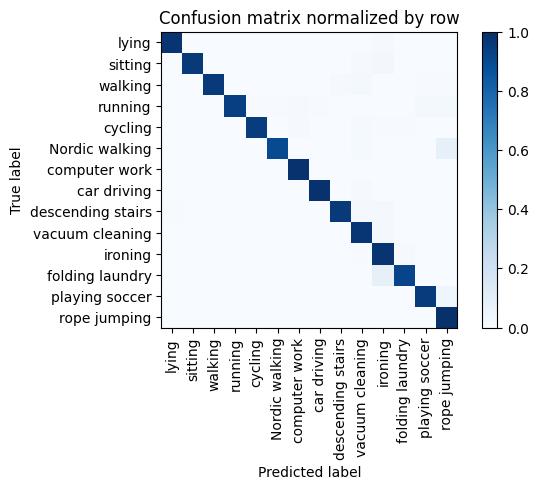

Overall accuracy: 0.963



unseen: 100%|██████████| 175/175 [00:12<00:00, 13.66batch/s, loss=0]       


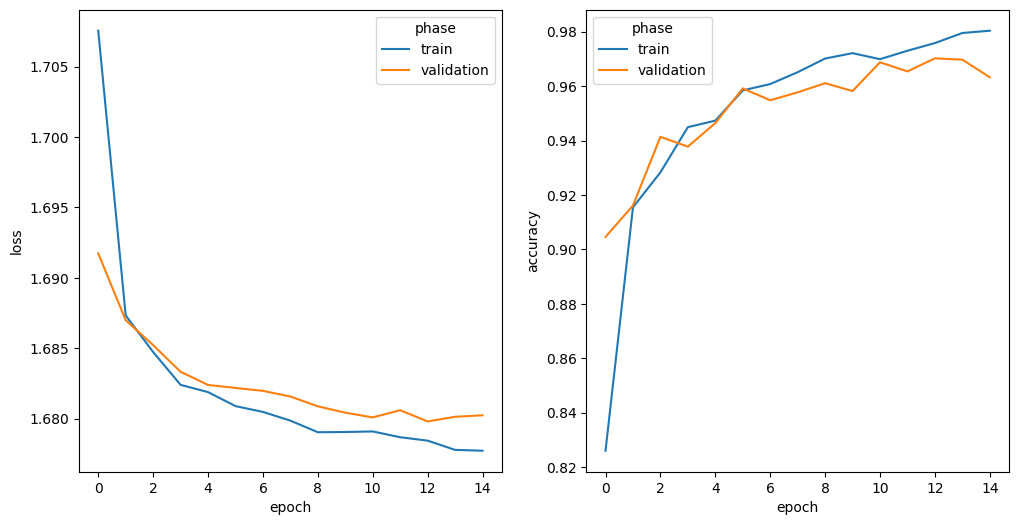

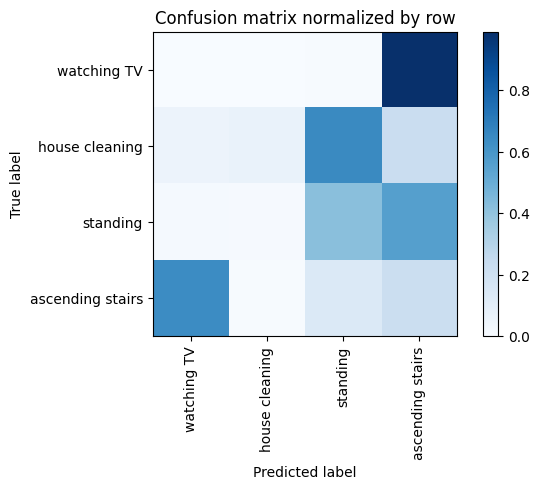

Overall accuracy: 0.203

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.365      0.418      0.390      0.330       1850|	 ascending stairs: 0.559,	watching TV: 0.014,	
  house cleaning       0.836      0.066      0.123      0.329       1840|	 standing: 0.648,	ascending stairs: 0.228,	
ascending stairs       0.094      0.218      0.131      0.193       1081|	 watching TV: 0.638,	standing: 0.137,	
     watching TV       0.004      0.004      0.004      0.148        829|	 ascending stairs: 0.989,	standing: 0.007,	

----------------------------------------------------------------------------------------------------
     avg / total       0.414      0.203      0.195        1.0       5600|	      

{'accuracy': 0.20267857142857143, 'precision': 0.3245602001492577, 'recall': 0.17665447944633242, 'f1': 0.16194808689196313, 'loss': 0.00032355248262839657}
================ Fold-1 ================
Initiate IMU datasets ...
Initi

seen: 100%|██████████| 131/131 [00:08<00:00, 15.99batch/s, loss=1.7]


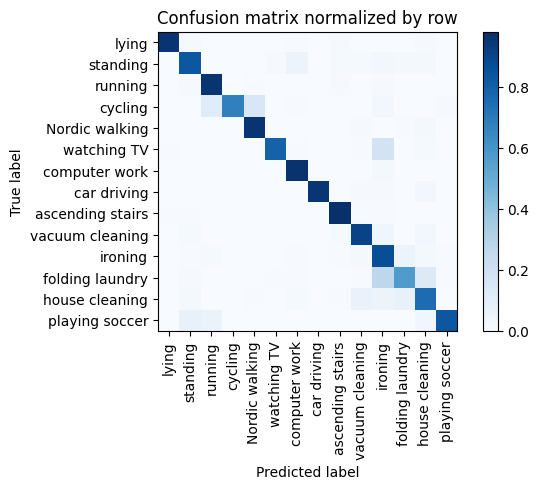

Training Epoch:   7%|▋         | 1/15 [01:05<15:21, 65.86s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 131/131 [00:08<00:00, 15.56batch/s, loss=1.68]


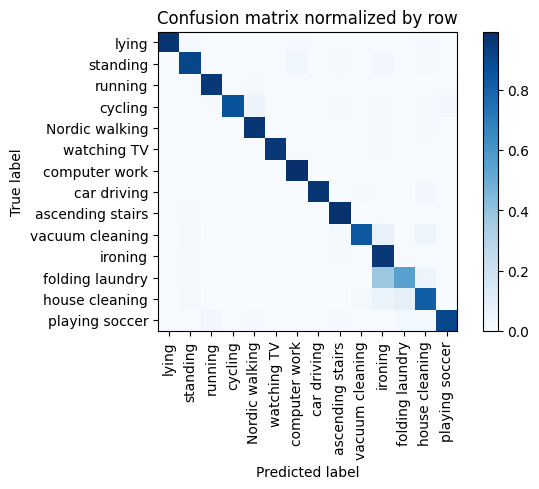

Training Epoch:  13%|█▎        | 2/15 [02:08<13:53, 64.11s/it]

Overall accuracy: 0.913



seen: 100%|██████████| 131/131 [00:09<00:00, 14.42batch/s, loss=1.69]


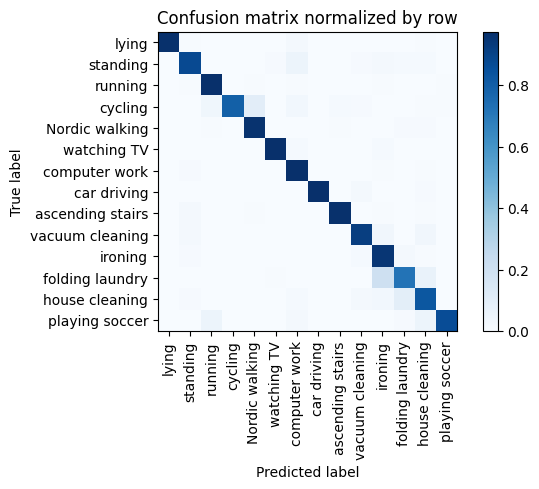

Training Epoch:  20%|██        | 3/15 [03:17<13:12, 66.01s/it]

Overall accuracy: 0.915



seen: 100%|██████████| 131/131 [00:08<00:00, 16.30batch/s, loss=1.69]


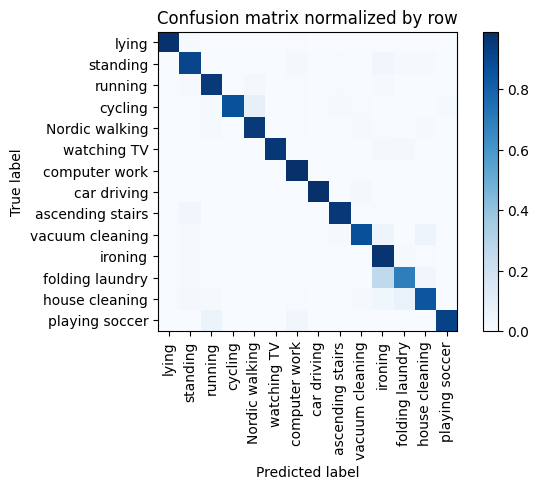

Training Epoch:  27%|██▋       | 4/15 [04:21<11:59, 65.37s/it]

Overall accuracy: 0.922



seen: 100%|██████████| 131/131 [00:08<00:00, 14.62batch/s, loss=1.7]


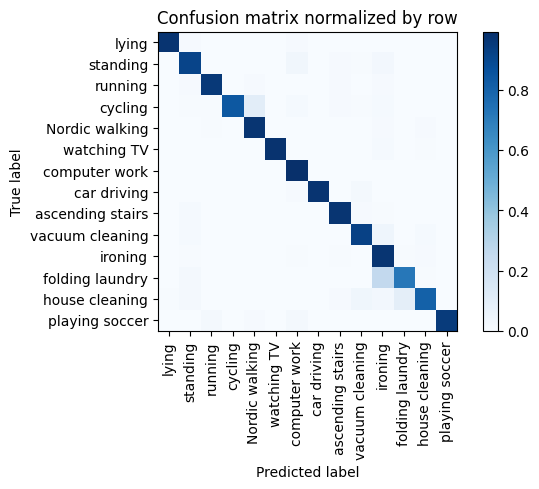

Training Epoch:  33%|███▎      | 5/15 [05:24<10:45, 64.59s/it]

Overall accuracy: 0.929



seen: 100%|██████████| 131/131 [00:08<00:00, 15.46batch/s, loss=1.69]


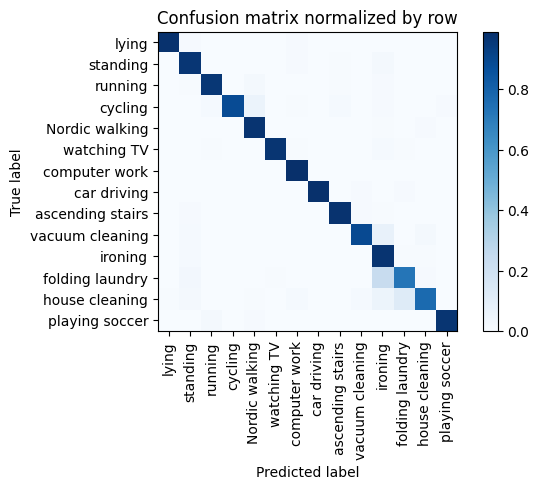

Training Epoch:  40%|████      | 6/15 [06:31<09:49, 65.52s/it]

Overall accuracy: 0.932



seen: 100%|██████████| 131/131 [00:08<00:00, 15.23batch/s, loss=1.69]


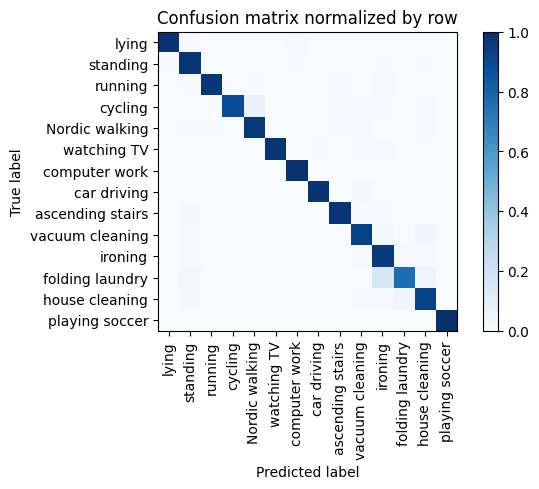

Training Epoch:  47%|████▋     | 7/15 [07:35<08:38, 64.76s/it]

Overall accuracy: 0.950



seen: 100%|██████████| 131/131 [00:09<00:00, 14.41batch/s, loss=1.69]


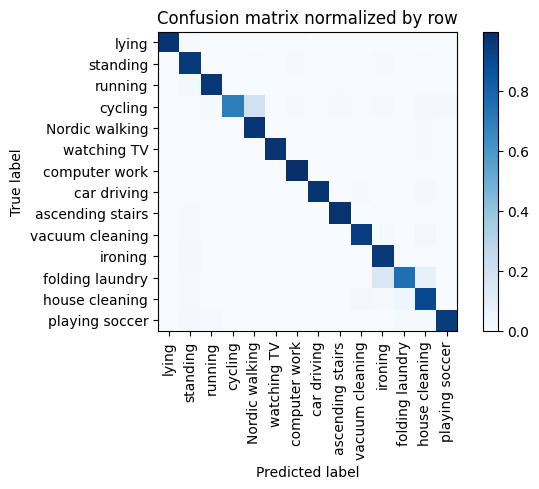

Training Epoch:  53%|█████▎    | 8/15 [08:43<07:40, 65.84s/it]

Overall accuracy: 0.932



seen: 100%|██████████| 131/131 [00:08<00:00, 16.35batch/s, loss=1.68]


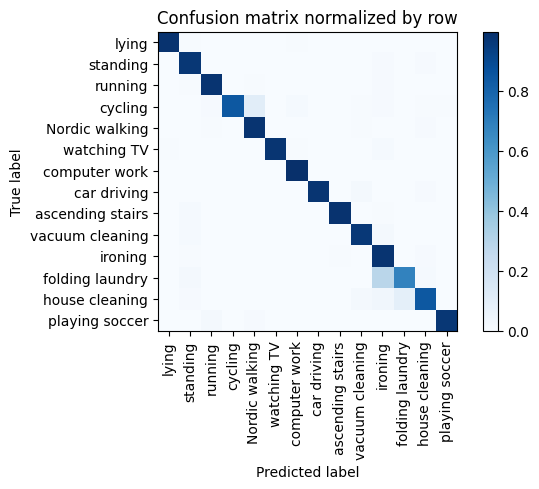

Training Epoch:  60%|██████    | 9/15 [09:46<06:30, 65.16s/it]

Overall accuracy: 0.942



seen: 100%|██████████| 131/131 [00:08<00:00, 15.70batch/s, loss=1.69]


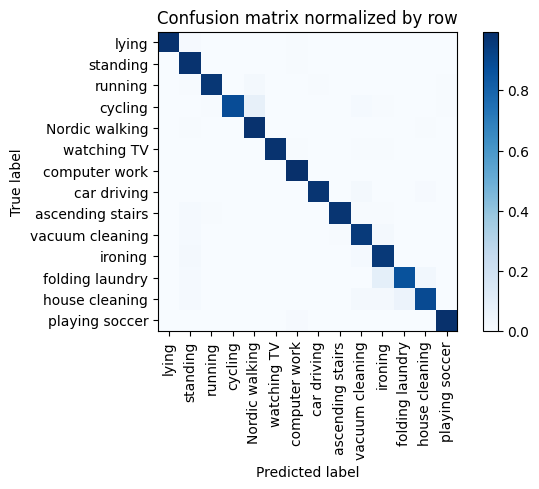

Training Epoch:  67%|██████▋   | 10/15 [10:51<05:24, 64.86s/it]

Overall accuracy: 0.957



seen: 100%|██████████| 131/131 [00:08<00:00, 15.60batch/s, loss=1.69]


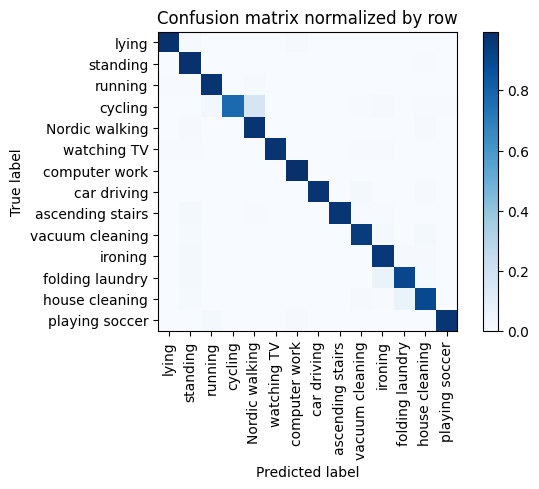

Training Epoch:  73%|███████▎  | 11/15 [11:54<04:18, 64.51s/it]

Overall accuracy: 0.949



seen: 100%|██████████| 131/131 [00:09<00:00, 13.16batch/s, loss=1.69]


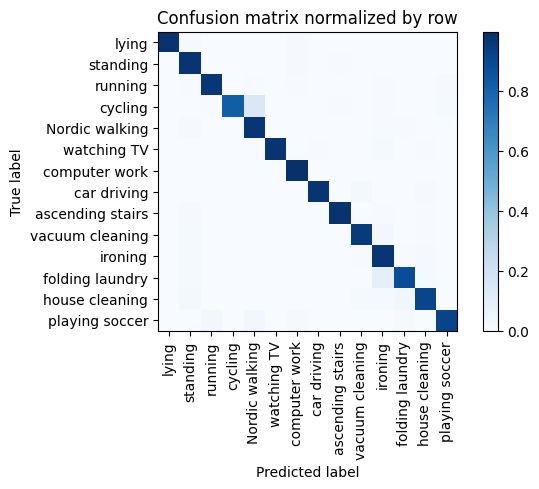

Training Epoch:  80%|████████  | 12/15 [13:03<03:17, 65.85s/it]

Overall accuracy: 0.952



seen: 100%|██████████| 131/131 [00:08<00:00, 15.73batch/s, loss=1.68]


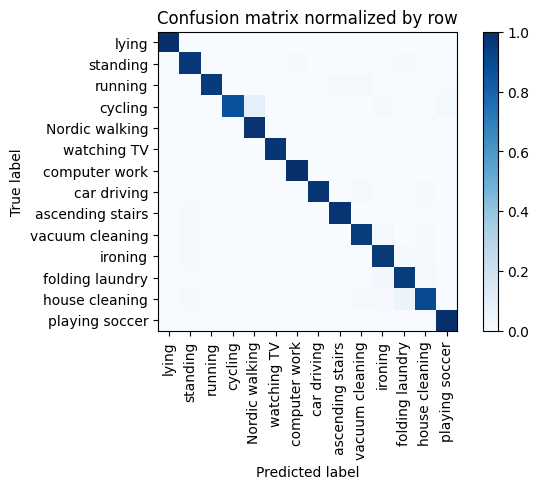

Training Epoch:  87%|████████▋ | 13/15 [14:15<02:15, 67.71s/it]

Overall accuracy: 0.958



seen: 100%|██████████| 131/131 [00:08<00:00, 14.97batch/s, loss=1.69]


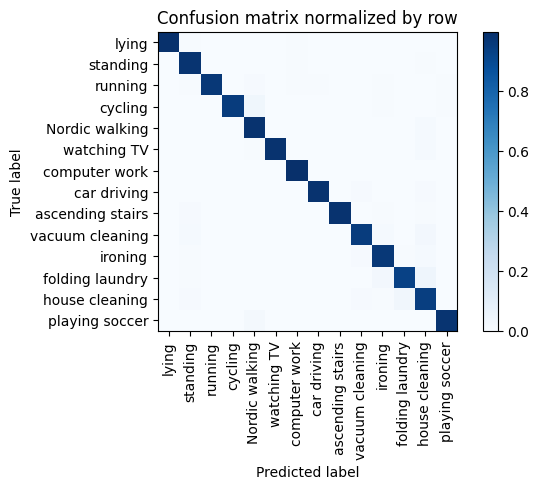

Training Epoch:  93%|█████████▎| 14/15 [15:26<01:08, 68.64s/it]

Overall accuracy: 0.969



seen: 100%|██████████| 131/131 [00:08<00:00, 16.24batch/s, loss=1.68]


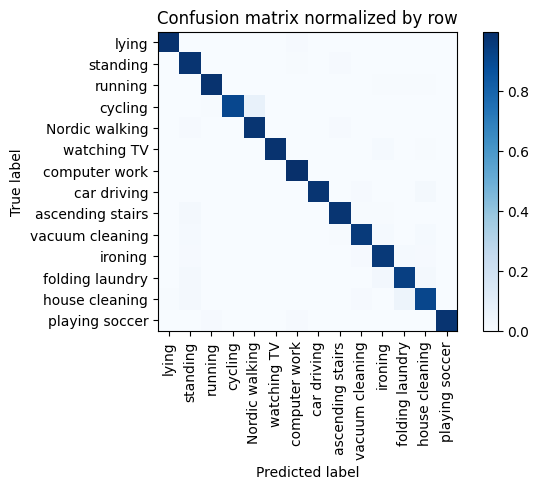

Overall accuracy: 0.964



unseen: 100%|██████████| 173/173 [00:29<00:00,  5.90batch/s, loss=0.00743]


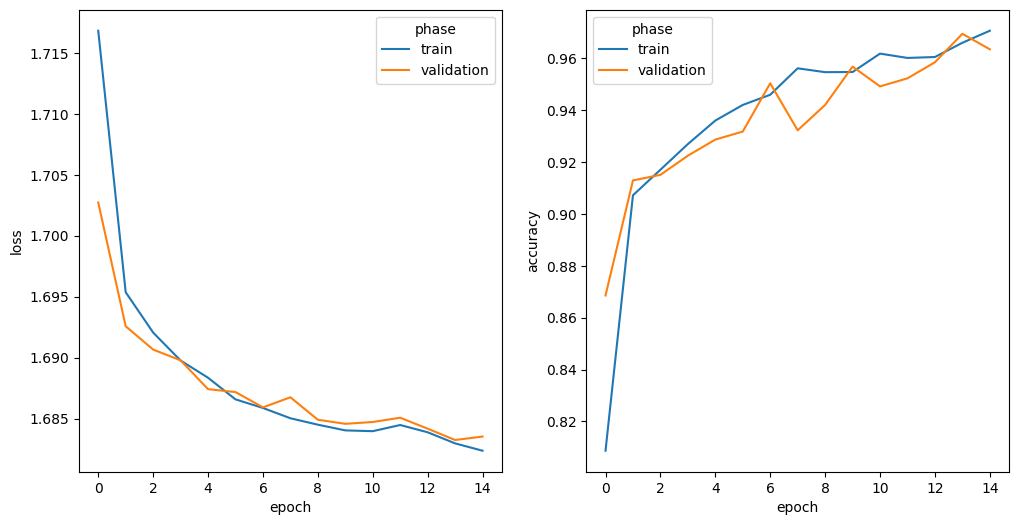

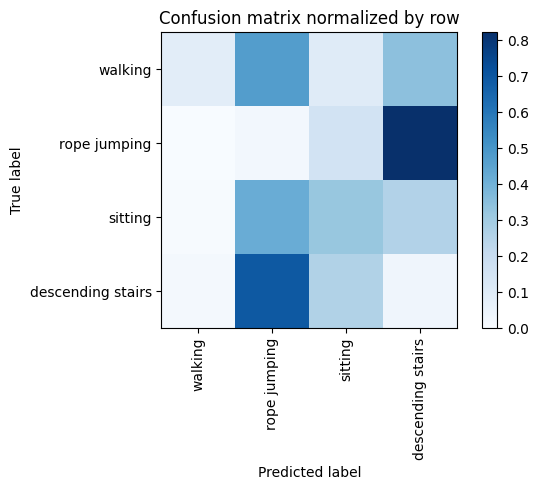

Overall accuracy: 0.148

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.910      0.086      0.158      0.421       2328|	 rope jumping: 0.471,	descending stairs: 0.344,	sitting: 0.099,	
          sitting       0.514      0.322      0.396      0.325       1800|	 rope jumping: 0.417,	descending stairs: 0.257,	
descending stairs       0.019      0.033      0.024      0.171        948|	 rope jumping: 0.694,	sitting: 0.259,	
     rope jumping       0.004      0.022      0.007      0.083        460|	 descending stairs: 0.824,	sitting: 0.154,	

----------------------------------------------------------------------------------------------------
      avg / total       0.553      0.148      0.200        1.0       5536|	      

{'accuracy': 0.1483020231213873, 'precision': 0.36155162889433895, 'recall': 0.11561160630698614, 'f1': 0.14595994970849466, 'loss': 0.008049166866314376}
================ Fold-2 ================
Init

seen: 100%|██████████| 121/121 [00:07<00:00, 16.02batch/s, loss=1.69]


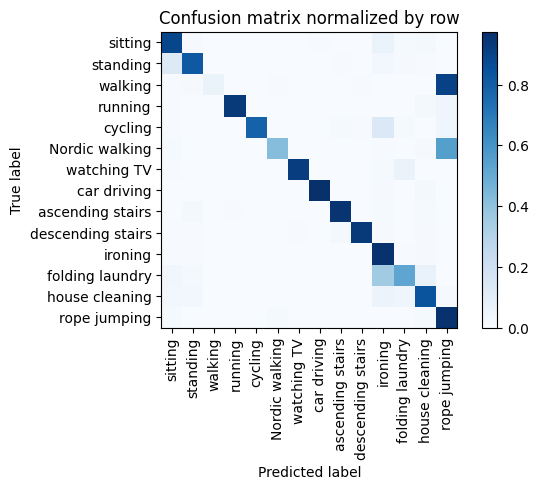

Training Epoch:   7%|▋         | 1/15 [01:02<14:34, 62.46s/it]

Overall accuracy: 0.728



seen: 100%|██████████| 121/121 [00:07<00:00, 15.76batch/s, loss=1.7]


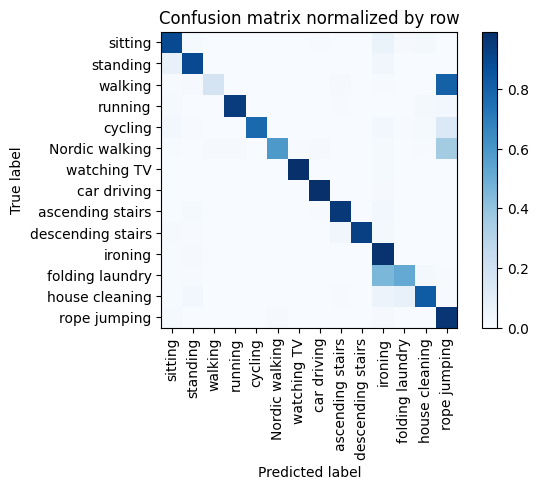

Training Epoch:  13%|█▎        | 2/15 [02:00<12:54, 59.61s/it]

Overall accuracy: 0.764



seen: 100%|██████████| 121/121 [00:07<00:00, 15.53batch/s, loss=1.68]


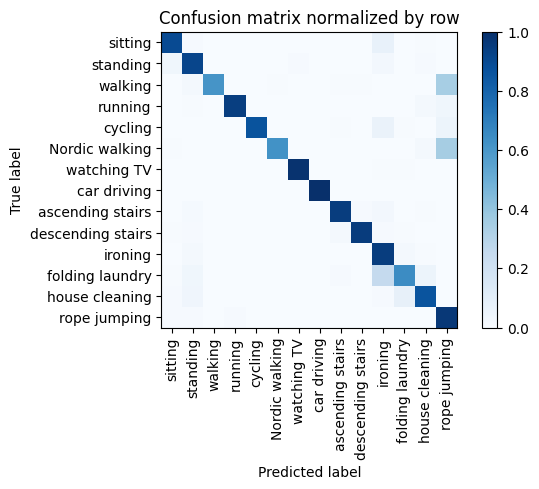

Training Epoch:  20%|██        | 3/15 [02:58<11:50, 59.23s/it]

Overall accuracy: 0.841



seen: 100%|██████████| 121/121 [00:07<00:00, 15.23batch/s, loss=1.7]


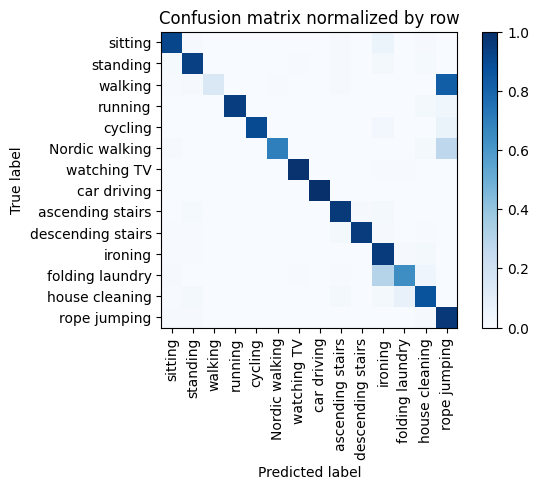

Training Epoch:  27%|██▋       | 4/15 [03:57<10:49, 59.01s/it]

Overall accuracy: 0.798



seen: 100%|██████████| 121/121 [00:07<00:00, 15.93batch/s, loss=1.69]


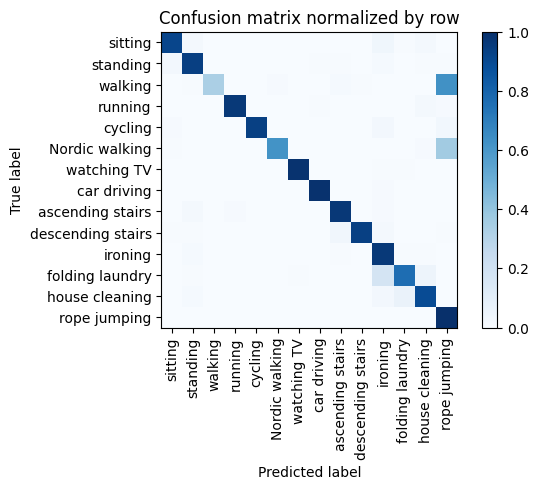

Training Epoch:  33%|███▎      | 5/15 [04:56<09:49, 58.97s/it]

Overall accuracy: 0.829



seen: 100%|██████████| 121/121 [00:07<00:00, 15.85batch/s, loss=1.68]


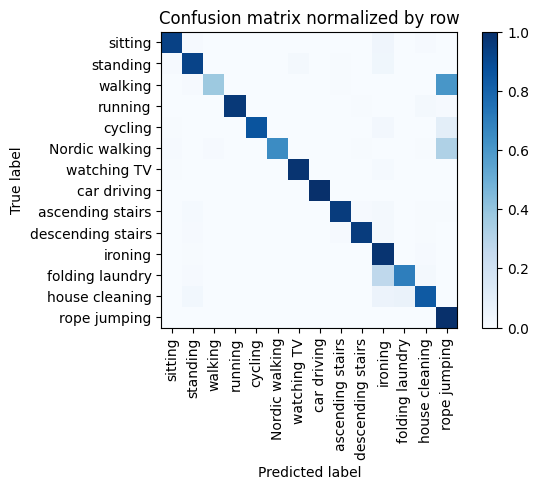

Training Epoch:  40%|████      | 6/15 [05:55<08:50, 58.98s/it]

Overall accuracy: 0.824



seen: 100%|██████████| 121/121 [00:07<00:00, 15.21batch/s, loss=1.7]


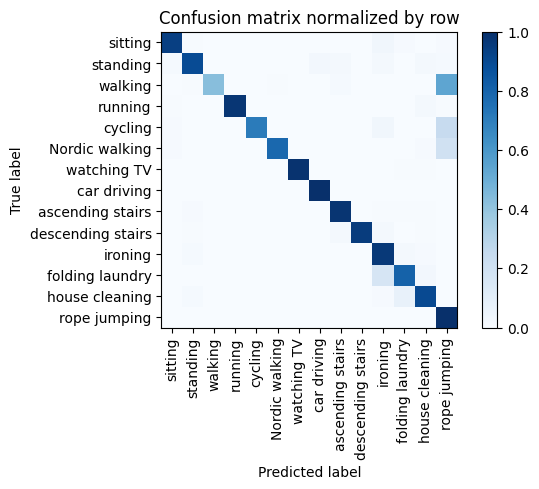

Training Epoch:  47%|████▋     | 7/15 [06:59<08:03, 60.49s/it]

Overall accuracy: 0.840



seen: 100%|██████████| 121/121 [00:07<00:00, 15.82batch/s, loss=1.69]


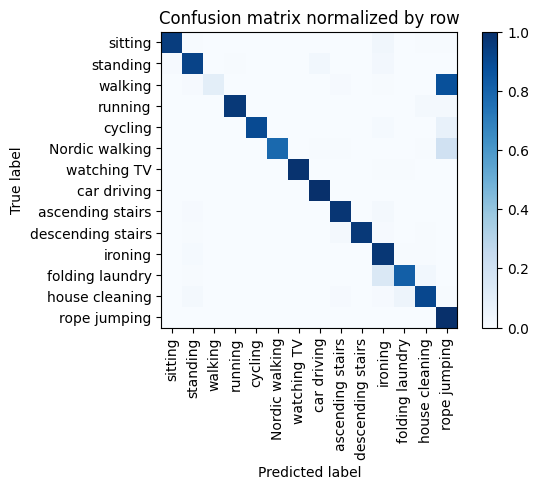

Training Epoch:  53%|█████▎    | 8/15 [07:58<07:00, 60.12s/it]

Overall accuracy: 0.821



seen: 100%|██████████| 121/121 [00:08<00:00, 14.74batch/s, loss=1.69]


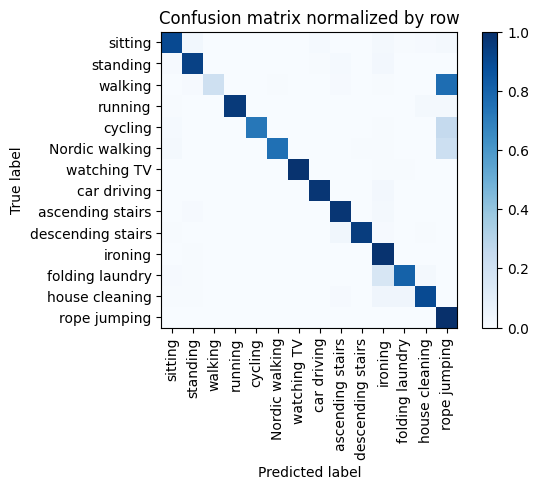

Training Epoch:  60%|██████    | 9/15 [09:02<06:08, 61.42s/it]

Overall accuracy: 0.811



seen: 100%|██████████| 121/121 [00:07<00:00, 16.54batch/s, loss=1.7]


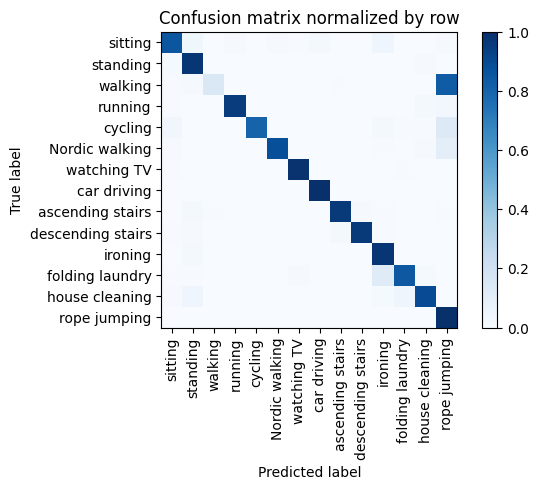

Training Epoch:  67%|██████▋   | 10/15 [10:01<05:03, 60.79s/it]

Overall accuracy: 0.822



seen: 100%|██████████| 121/121 [00:09<00:00, 12.92batch/s, loss=1.71]


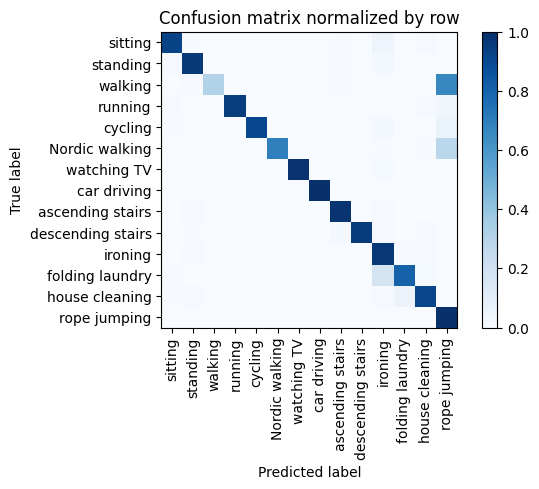

Training Epoch:  73%|███████▎  | 11/15 [11:06<04:07, 61.89s/it]

Overall accuracy: 0.841



seen: 100%|██████████| 121/121 [00:08<00:00, 14.75batch/s, loss=1.69]


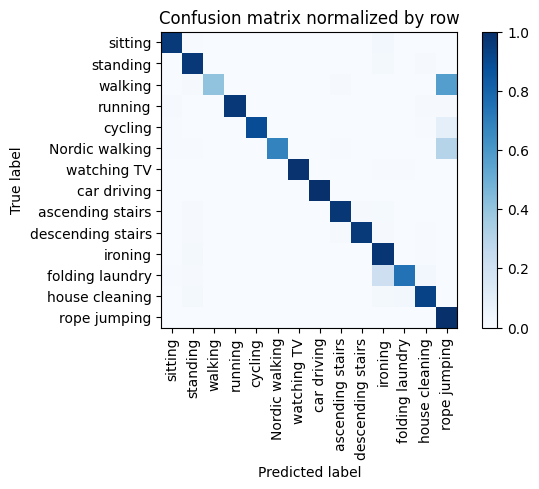

Training Epoch:  80%|████████  | 12/15 [12:07<03:05, 61.76s/it]

Overall accuracy: 0.852



seen: 100%|██████████| 121/121 [00:08<00:00, 14.90batch/s, loss=1.68]


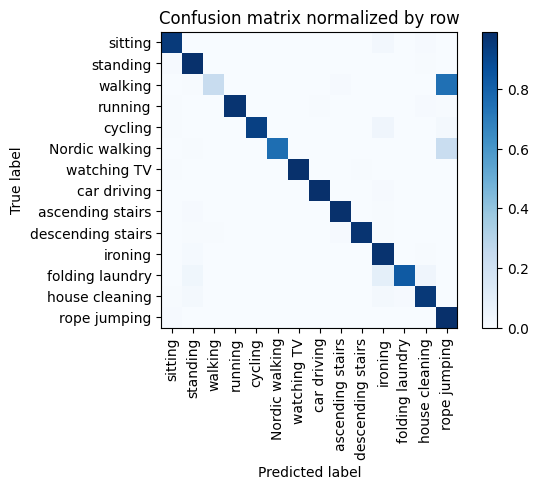

Training Epoch:  87%|████████▋ | 13/15 [13:08<02:02, 61.35s/it]

Overall accuracy: 0.851



seen: 100%|██████████| 121/121 [00:07<00:00, 16.19batch/s, loss=1.69]


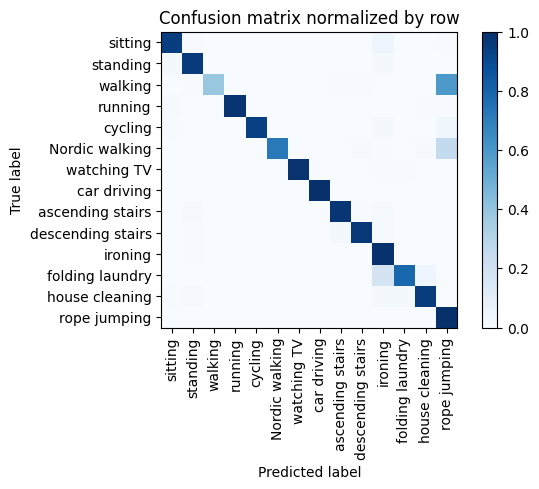

Training Epoch:  93%|█████████▎| 14/15 [14:07<01:00, 60.67s/it]

Overall accuracy: 0.862



seen: 100%|██████████| 121/121 [00:06<00:00, 18.89batch/s, loss=1.68]


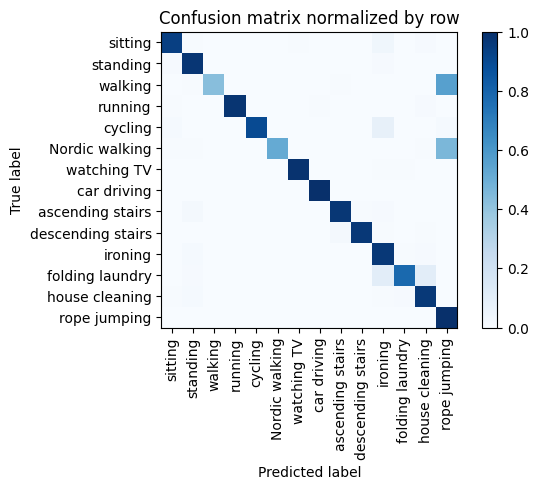

Overall accuracy: 0.844



unseen: 100%|██████████| 222/222 [00:15<00:00, 14.52batch/s, loss=0.00316] 


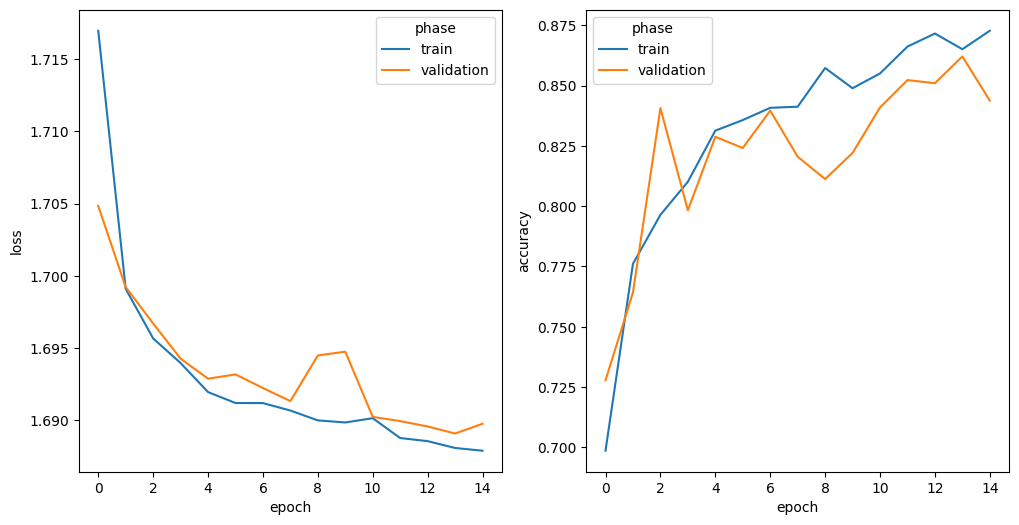

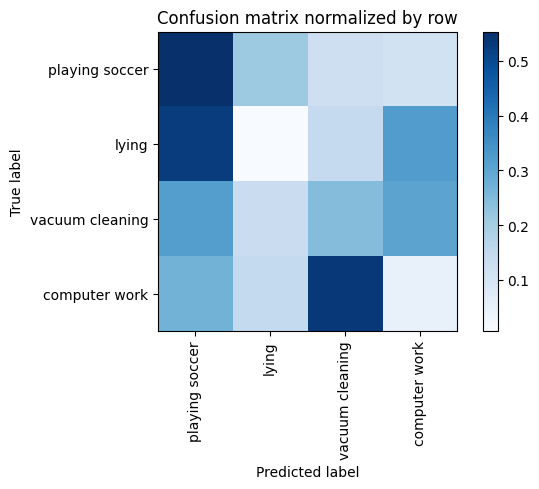

Overall accuracy: 0.118

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.115      0.050      0.070      0.432       3069|	 vacuum cleaning: 0.535,	playing soccer: 0.268,	lying: 0.147,	
          lying       0.019      0.008      0.011      0.264       1874|	 playing soccer: 0.526,	computer work: 0.321,	vacuum cleaning: 0.146,	
vacuum cleaning       0.175      0.245      0.204      0.240       1703|	 playing soccer: 0.317,	computer work: 0.305,	
 playing soccer       0.097      0.552      0.165      0.064        458|	 lying: 0.212,	vacuum cleaning: 0.124,	

----------------------------------------------------------------------------------------------------
    avg / total       0.103      0.118      0.093        1.0       7104|	      

{'accuracy': 0.11810247747747747, 'precision': 0.10166822731473882, 'recall': 0.2139271488459033, 'f1': 0.1126437087797281, 'loss': 0.0060722085810895705}
================ Fold-3 =========

seen: 100%|██████████| 138/138 [00:08<00:00, 16.67batch/s, loss=1.72]


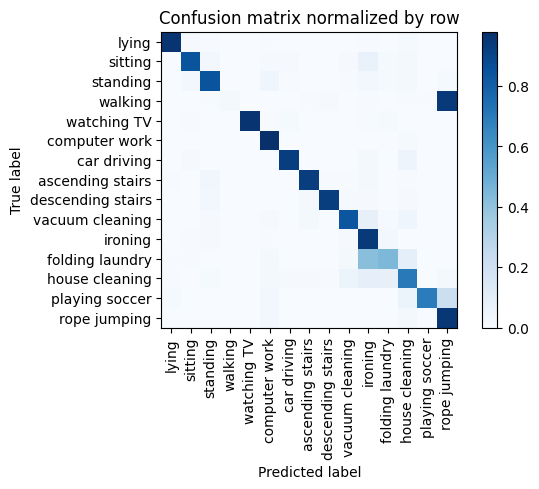

Training Epoch:   7%|▋         | 1/15 [01:10<16:28, 70.62s/it]

Overall accuracy: 0.783



seen: 100%|██████████| 138/138 [00:08<00:00, 16.87batch/s, loss=1.72]


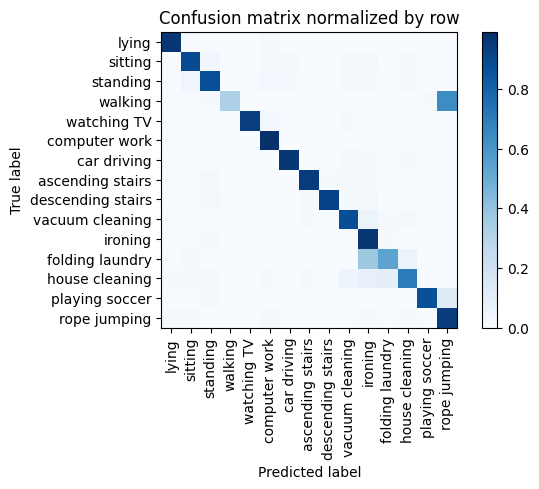

Training Epoch:  13%|█▎        | 2/15 [02:16<14:40, 67.72s/it]

Overall accuracy: 0.834



seen: 100%|██████████| 138/138 [00:08<00:00, 16.07batch/s, loss=1.74]


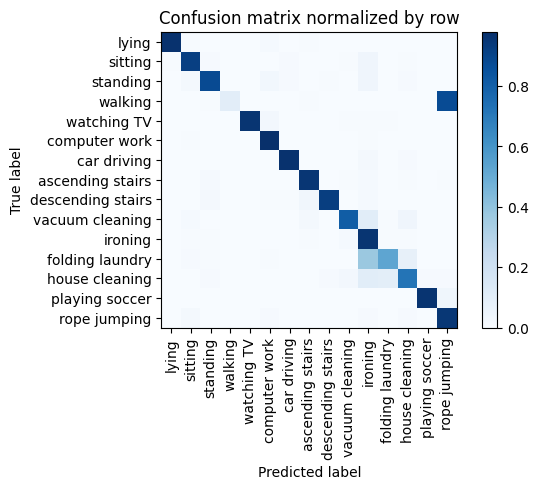

Training Epoch:  20%|██        | 3/15 [03:22<13:21, 66.82s/it]

Overall accuracy: 0.813



seen: 100%|██████████| 138/138 [00:08<00:00, 17.24batch/s, loss=1.75]


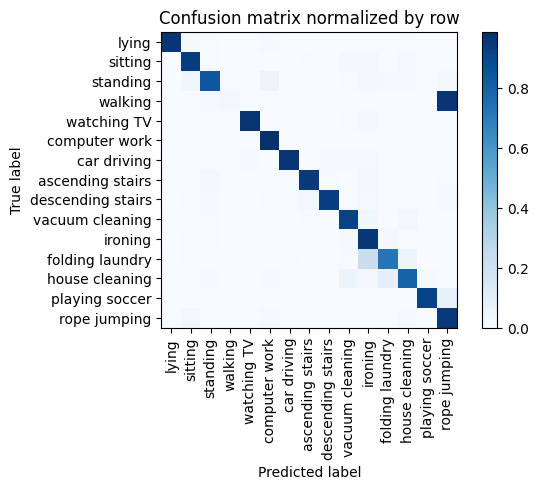

Training Epoch:  27%|██▋       | 4/15 [04:25<11:59, 65.38s/it]

Overall accuracy: 0.826



seen: 100%|██████████| 138/138 [00:07<00:00, 17.46batch/s, loss=1.71]


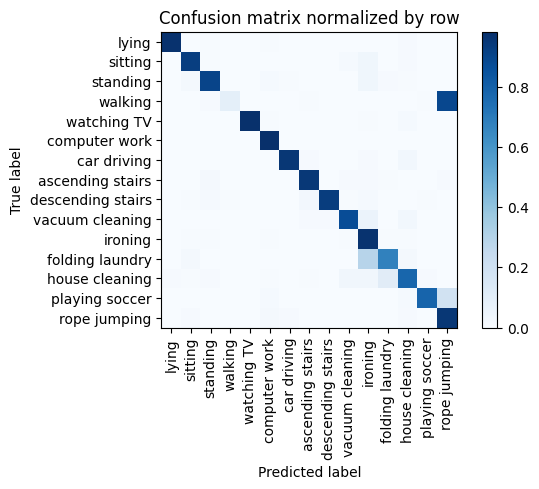

Training Epoch:  33%|███▎      | 5/15 [05:28<10:44, 64.47s/it]

Overall accuracy: 0.829



seen: 100%|██████████| 138/138 [00:07<00:00, 17.69batch/s, loss=1.74]


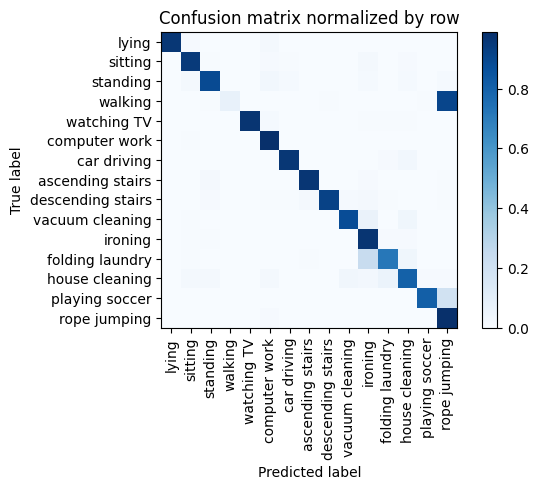

Training Epoch:  40%|████      | 6/15 [06:32<09:38, 64.30s/it]

Overall accuracy: 0.834



seen: 100%|██████████| 138/138 [00:08<00:00, 17.22batch/s, loss=1.73]


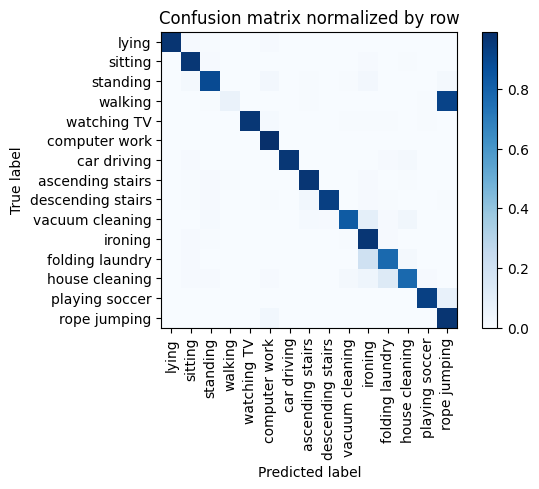

Training Epoch:  47%|████▋     | 7/15 [07:34<08:28, 63.56s/it]

Overall accuracy: 0.833



seen: 100%|██████████| 138/138 [00:07<00:00, 17.34batch/s, loss=1.72]


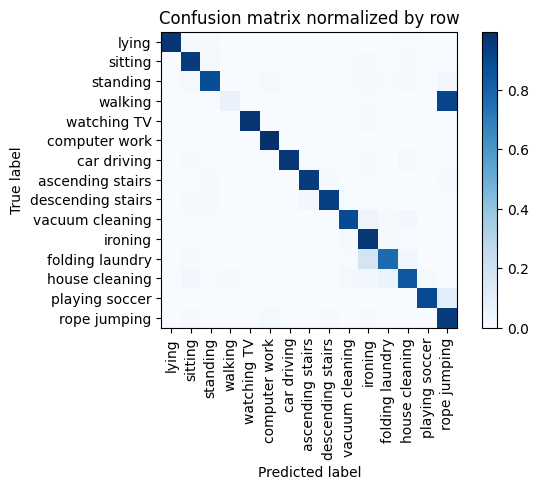

Training Epoch:  53%|█████▎    | 8/15 [08:37<07:24, 63.50s/it]

Overall accuracy: 0.842



seen: 100%|██████████| 138/138 [00:07<00:00, 17.70batch/s, loss=1.73]


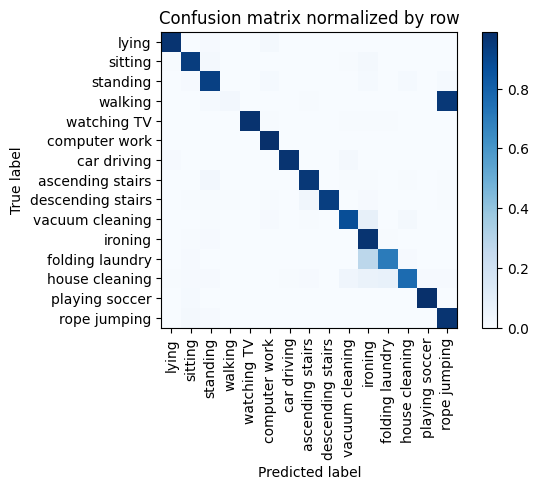

Training Epoch:  60%|██████    | 9/15 [09:40<06:20, 63.38s/it]

Overall accuracy: 0.832



seen: 100%|██████████| 138/138 [00:07<00:00, 17.70batch/s, loss=1.72]


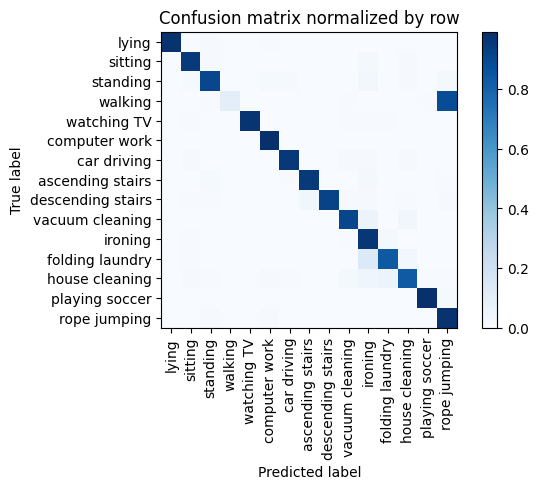

Training Epoch:  67%|██████▋   | 10/15 [10:41<05:13, 62.77s/it]

Overall accuracy: 0.853



seen: 100%|██████████| 138/138 [00:06<00:00, 19.99batch/s, loss=1.72]


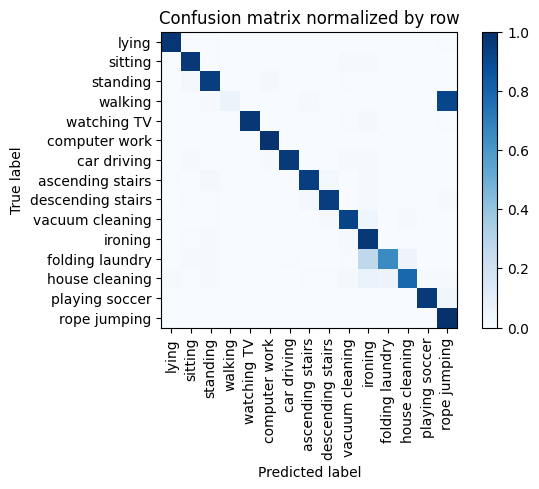

Training Epoch:  73%|███████▎  | 11/15 [11:42<04:08, 62.19s/it]

Overall accuracy: 0.842



seen: 100%|██████████| 138/138 [00:09<00:00, 14.60batch/s, loss=1.72]


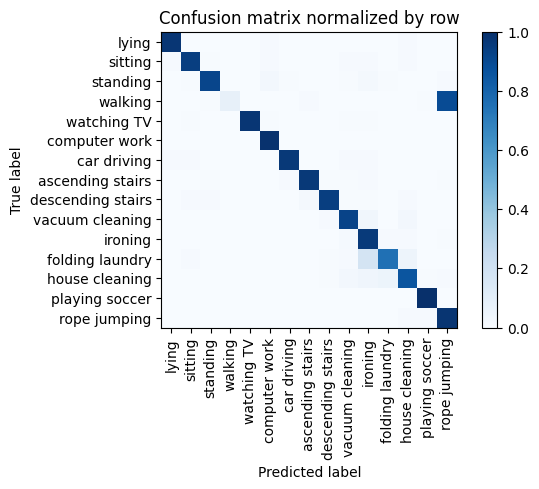

Training Epoch:  80%|████████  | 12/15 [12:42<03:04, 61.39s/it]

Overall accuracy: 0.851



seen: 100%|██████████| 138/138 [00:07<00:00, 17.64batch/s, loss=1.72]


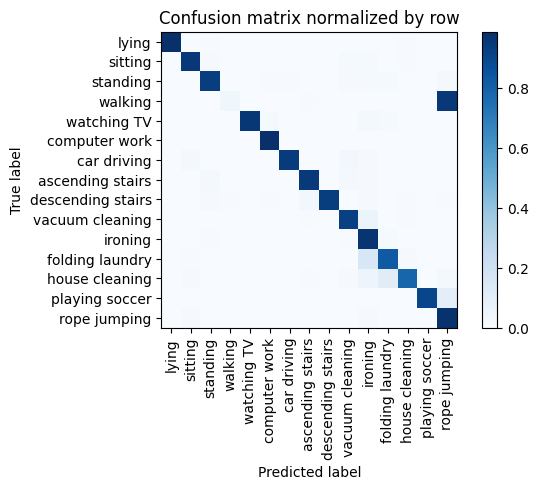

Training Epoch:  87%|████████▋ | 13/15 [13:46<02:04, 62.36s/it]

Overall accuracy: 0.844



seen: 100%|██████████| 138/138 [00:08<00:00, 16.09batch/s, loss=1.74]


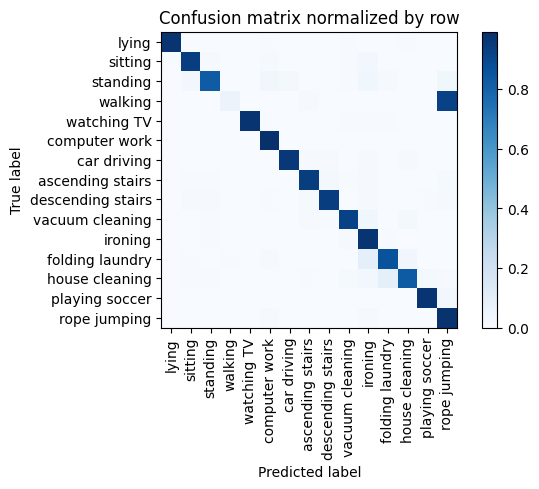

Training Epoch:  93%|█████████▎| 14/15 [14:54<01:04, 64.03s/it]

Overall accuracy: 0.844



seen: 100%|██████████| 138/138 [00:09<00:00, 14.35batch/s, loss=1.74]


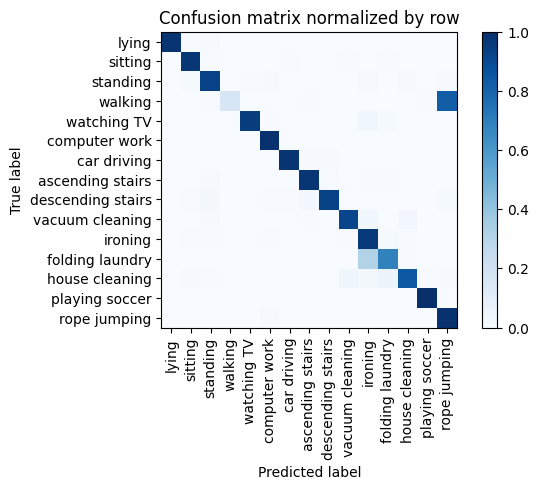

Overall accuracy: 0.857



unseen: 100%|██████████| 137/137 [00:17<00:00,  8.06batch/s, loss=0]       


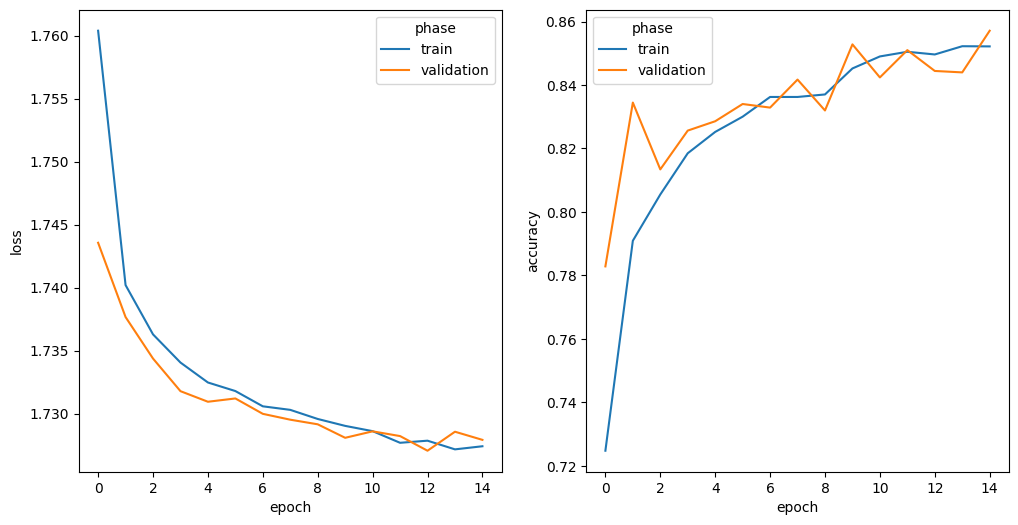

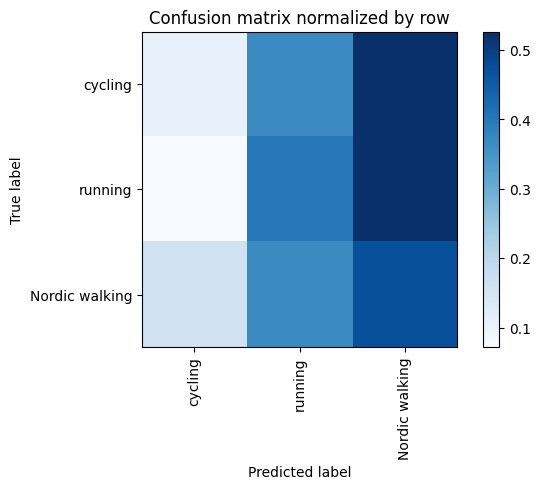

Overall accuracy: 0.323

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.393      0.471      0.428      0.419       1838|	 running: 0.370,	cycling: 0.159,	
       cycling       0.322      0.107      0.160      0.365       1600|	 Nordic walking: 0.526,	running: 0.367,	
       running       0.231      0.402      0.293      0.216        946|	 Nordic walking: 0.526,	cycling: 0.072,	

----------------------------------------------------------------------------------------------------
   avg / total       0.332      0.323      0.301        1.0       4384|	      

{'accuracy': 0.323220802919708, 'precision': 0.31512006224975503, 'recall': 0.32657688031848203, 'f1': 0.2939555329818339, 'loss': 4.637829693740431e-05}
================ Fold-4 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


seen: 100%|██████████| 141/141 [00:08<00:00, 17.36batch/s, loss=1.75]


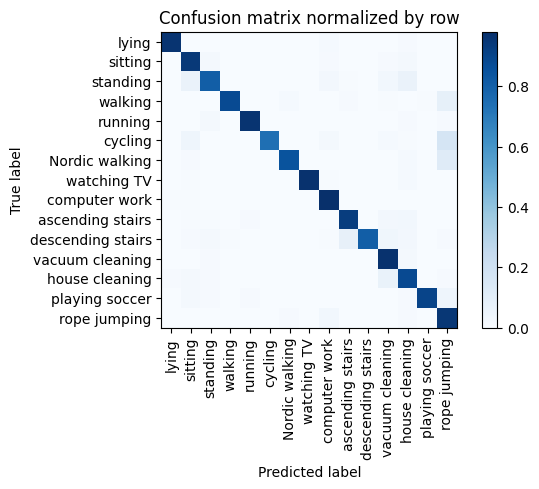

Training Epoch:   7%|▋         | 1/15 [01:03<14:52, 63.77s/it]

Overall accuracy: 0.902



seen: 100%|██████████| 141/141 [00:08<00:00, 16.94batch/s, loss=1.75]


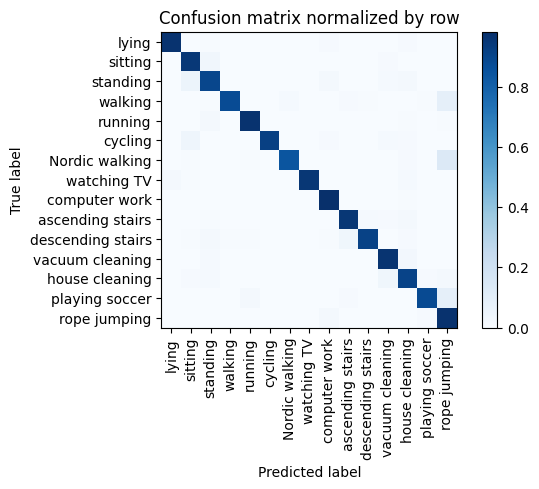

Training Epoch:  13%|█▎        | 2/15 [02:08<13:52, 64.05s/it]

Overall accuracy: 0.930



seen: 100%|██████████| 141/141 [00:07<00:00, 17.65batch/s, loss=1.73]


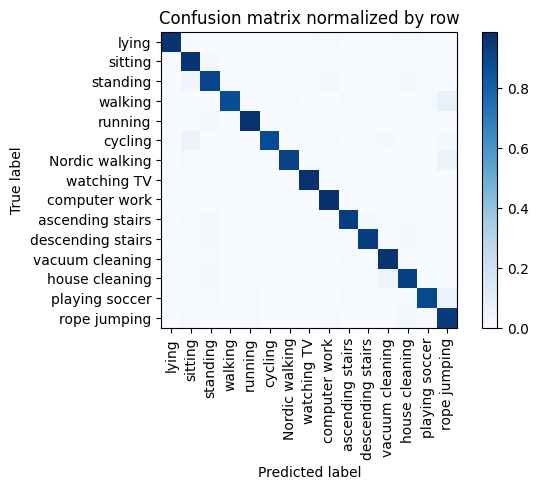

Training Epoch:  20%|██        | 3/15 [03:10<12:39, 63.25s/it]

Overall accuracy: 0.936



seen: 100%|██████████| 141/141 [00:07<00:00, 18.48batch/s, loss=1.74]


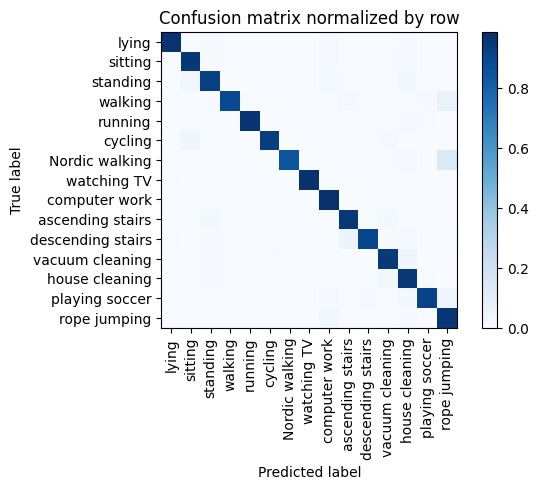

Training Epoch:  27%|██▋       | 4/15 [04:11<11:24, 62.27s/it]

Overall accuracy: 0.939



seen: 100%|██████████| 141/141 [00:07<00:00, 19.30batch/s, loss=1.74]


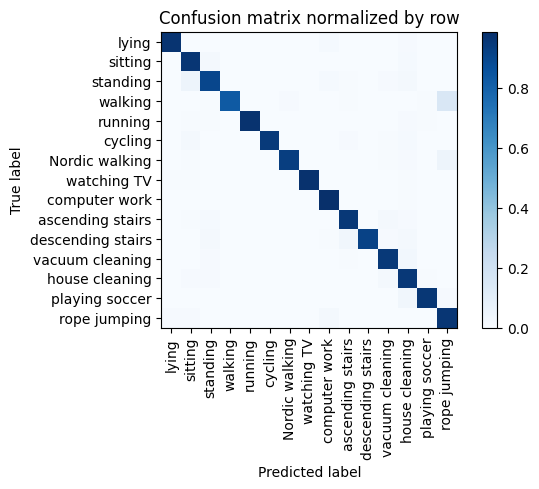

Training Epoch:  33%|███▎      | 5/15 [05:14<10:27, 62.74s/it]

Overall accuracy: 0.941



seen: 100%|██████████| 141/141 [00:08<00:00, 17.61batch/s, loss=1.74]


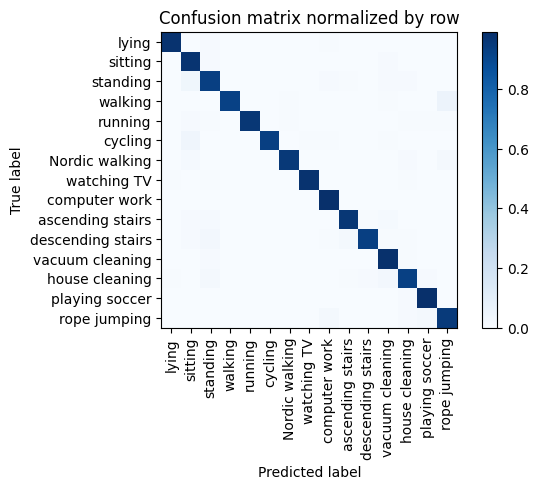

Training Epoch:  40%|████      | 6/15 [06:17<09:25, 62.82s/it]

Overall accuracy: 0.958



seen: 100%|██████████| 141/141 [00:07<00:00, 17.80batch/s, loss=1.74]


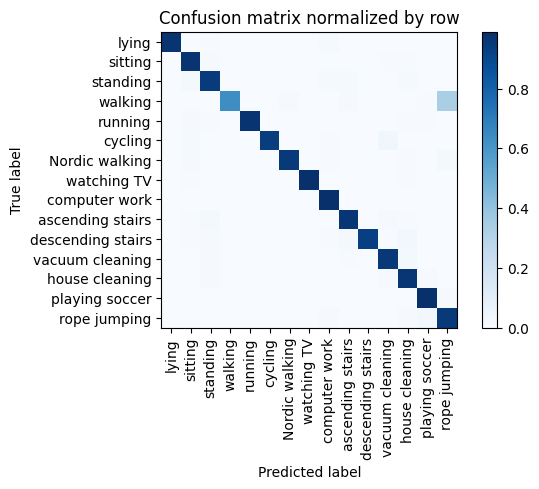

Training Epoch:  47%|████▋     | 7/15 [07:18<08:18, 62.31s/it]

Overall accuracy: 0.931



seen: 100%|██████████| 141/141 [00:07<00:00, 17.68batch/s, loss=1.74]


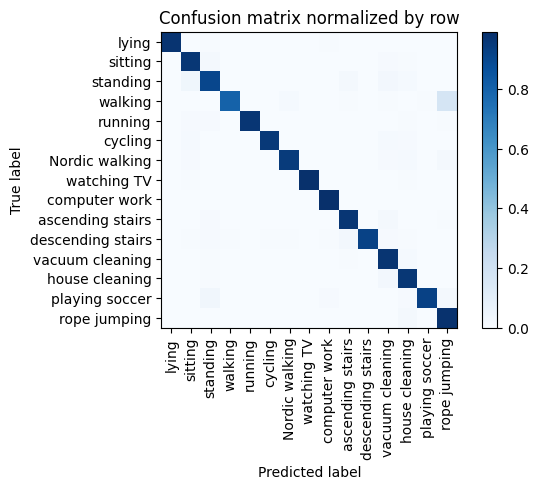

Training Epoch:  53%|█████▎    | 8/15 [08:22<07:19, 62.84s/it]

Overall accuracy: 0.945



seen: 100%|██████████| 141/141 [00:06<00:00, 20.52batch/s, loss=1.73]


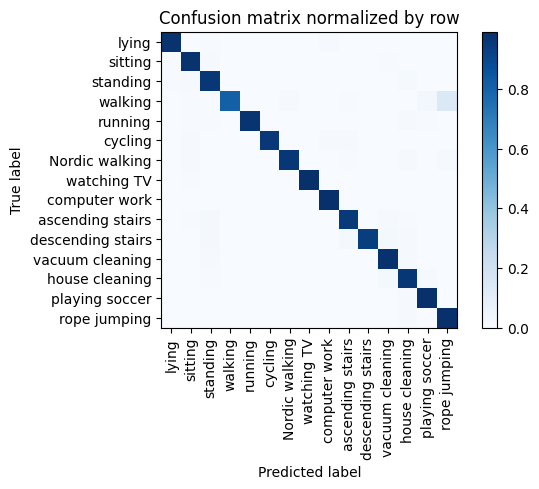

Training Epoch:  60%|██████    | 9/15 [09:21<06:09, 61.60s/it]

Overall accuracy: 0.956



seen: 100%|██████████| 141/141 [00:07<00:00, 17.85batch/s, loss=1.73]


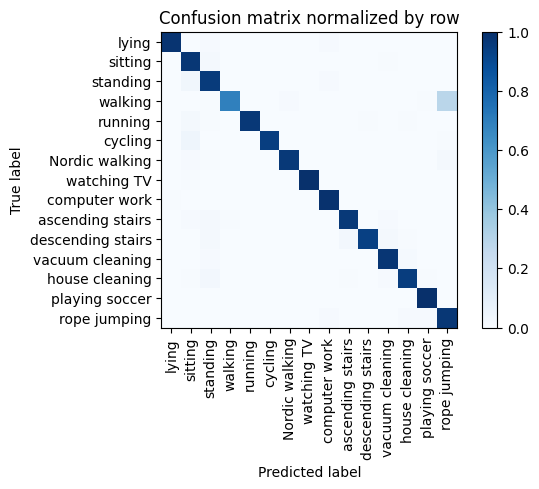

Training Epoch:  67%|██████▋   | 10/15 [10:23<05:07, 61.55s/it]

Overall accuracy: 0.939



seen: 100%|██████████| 141/141 [00:08<00:00, 17.21batch/s, loss=1.74]


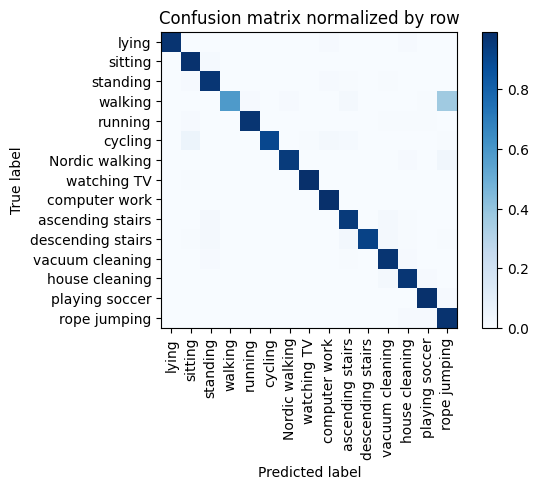

Training Epoch:  73%|███████▎  | 11/15 [11:28<04:10, 62.69s/it]

Overall accuracy: 0.927



seen: 100%|██████████| 141/141 [00:08<00:00, 17.58batch/s, loss=1.73]


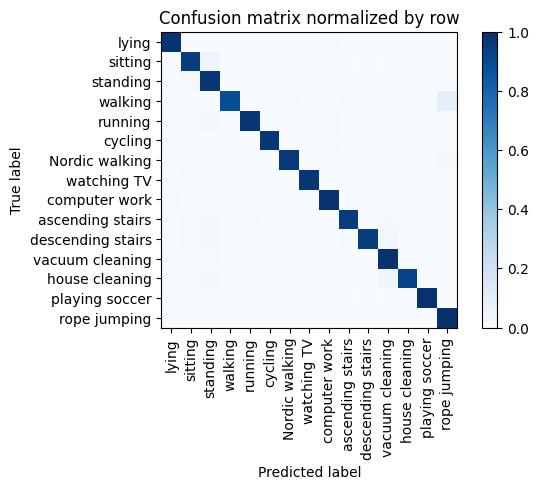

Training Epoch:  80%|████████  | 12/15 [12:31<03:08, 62.78s/it]

Overall accuracy: 0.959



seen: 100%|██████████| 141/141 [00:07<00:00, 18.15batch/s, loss=1.74]


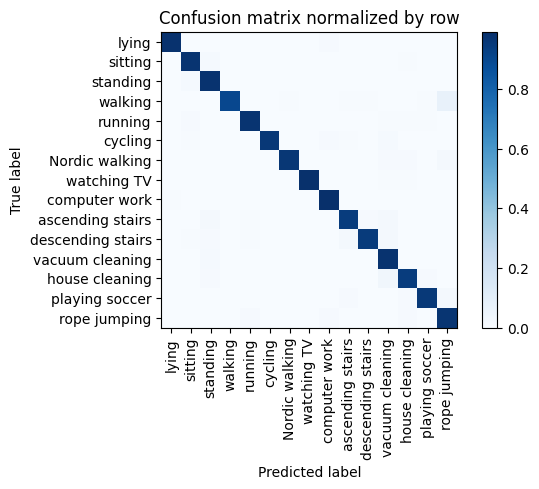

Training Epoch:  87%|████████▋ | 13/15 [13:34<02:05, 62.98s/it]

Overall accuracy: 0.963



seen: 100%|██████████| 141/141 [00:07<00:00, 17.82batch/s, loss=1.72]


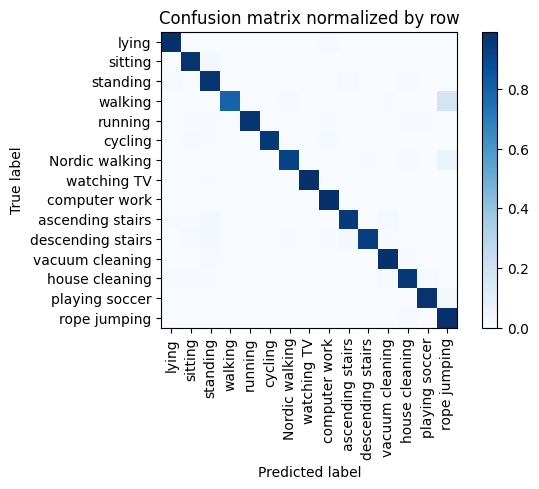

Training Epoch:  93%|█████████▎| 14/15 [14:37<01:02, 62.77s/it]

Overall accuracy: 0.953



seen: 100%|██████████| 141/141 [00:07<00:00, 17.89batch/s, loss=1.72]


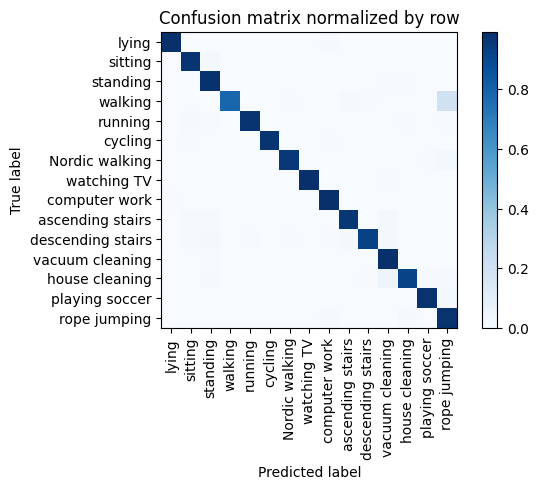

Overall accuracy: 0.953



unseen: 100%|██████████| 120/120 [00:13<00:00,  8.79batch/s, loss=0]       


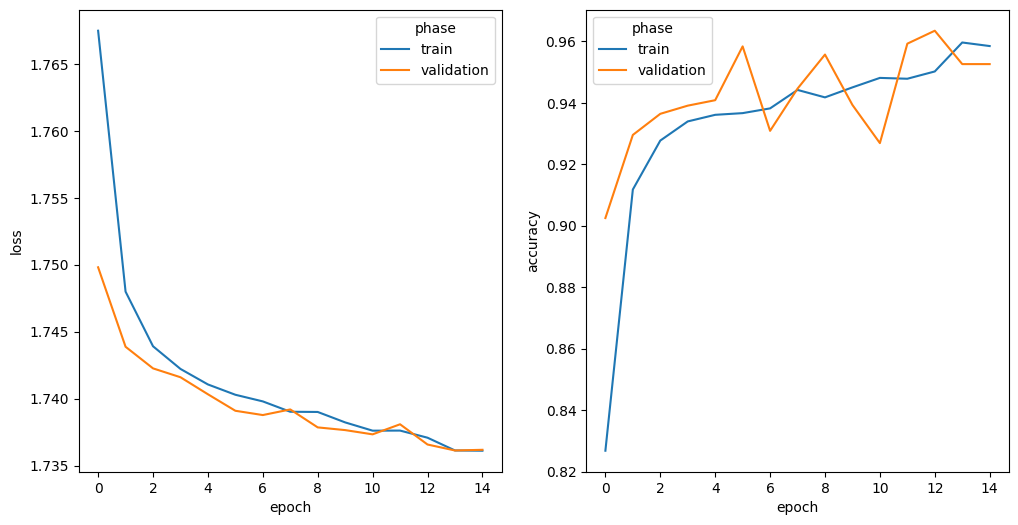

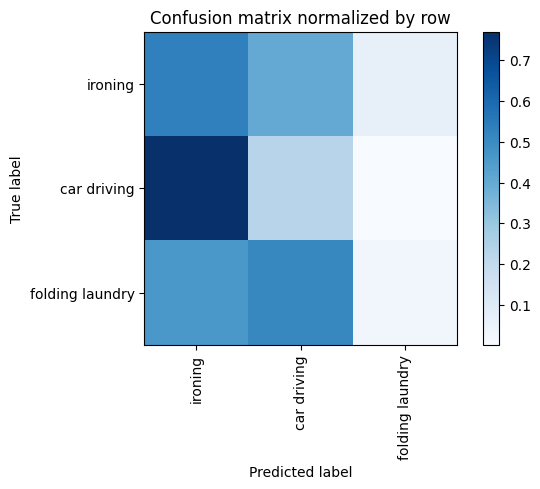

Overall accuracy: 0.362

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.591      0.532      0.560      0.608       2334|	 car driving: 0.404,	folding laundry: 0.064,	
folding laundry       0.152      0.028      0.047      0.253        971|	 car driving: 0.510,	ironing: 0.462,	
    car driving       0.078      0.228      0.117      0.139        535|	 ironing: 0.770,	folding laundry: 0.002,	

----------------------------------------------------------------------------------------------------
    avg / total       0.408      0.362      0.368        1.0       3840|	      

{'accuracy': 0.36223958333333334, 'precision': 0.27350852128560993, 'recall': 0.262659148146681, 'f1': 0.24111950580656352, 'loss': 0.0036897789942183104}
============== Overall Unseen Classes Performance ==============


accuracy     0.230909
precision    0.275282
recall       0.219086
f1           0.191125
loss         0.003636
dtype: float64

In [67]:
fold_metric_scores = []
t = datetime.now().strftime("%Y_%m_%d_%H_%M")

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    # print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=50)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=50)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=50)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    print("Initiate Skeleton dataset ... ")
    # build Skeleton dataset 
    skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
    skel_dl = DataLoader(skel_dt, batch_size=config['batch_size']//2, shuffle=True, pin_memory=True, drop_last=True)
    skel_n, skel_fts = skel_dt.getShape()
    
    print("Initial Models ...")
    # build IMU Encoder Model 
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    imu_model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    imu_model.to(device)

    # build AE Model 
    # ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
    # ae_model = SkeletonAE(seq_len=skel_n, input_size=skel_fts, hidden_size=512, linear_filters=[128,256,512], embedding_size=config['feat_size'], num_layers=1, bidirectional=True, batch_size=config['batch_size'], device=device)
    # ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
    ae_model.load_state_dict(torch.load(ae_trans_dir)['model_state_dict'])
    ae_model.to(device)
    
    # define IMU-Enc run parameters 
    seen_action_ft_dict = {a: get_class_ft(torch.from_numpy(skeleton_mov[i, ...]), ae_model, device) for a,i in action_dict.items() if a in seen_classes}
    seen_label_map = {i:l for i,l in enumerate(seen_classes)}
    trpLoss = ActionTripletLoss(seen_action_ft_dict, seen_label_map, distance='cosine', k=10, neg_thr=0.90,pos_thr=0.05, agg="mean", device=device)
    cceLoss = DistanceCCELoss(seen_action_ft_dict, seen_label_map, distance='cosine', k=10, neg_thr=0.90,pos_thr=0.05, agg="mean", device=device)

    # generate unseen semantic space 
    unseen_action_ft_dict = {a: get_class_ft(torch.from_numpy(skeleton_mov[i, ...]), ae_model, device) for a,i in action_dict.items() if a in unseen_classes}
    seen_label_map = {i:l for i,l in enumerate(unseen_classes)}

    seen_action_ft, seen_action_label = gen_semantic_space(seen_action_ft_dict)
    unseen_action_ft, unseen_action_label = gen_semantic_space(unseen_action_ft_dict)

    imu_optim = Adam(imu_model.parameters(), lr=config['imu_lr'])
    ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
    optimizers = {'imu': imu_optim, 'ae': ae_optim}

    imu_loss_module = {'class': cceLoss, 'feature': trpLoss}
    best_acc = 0.0

    print("Start Models training ...")
    fold_train_data = []
    fold_val_data = []  
    # train 2 models E2E
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
       # train IMU-Enc model
        train_metrics = imu_train_step1(imu_model, ae_model, train_dl, skel_dt, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes, phase='train', loss_alpha=config['imu_alpha'], batch_size=32)
        fold_train_data.append(train_metrics)
        eval_metrics, _, _ = eval_step1(imu_model, eval_dl, seen_action_ft, seen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes,  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=config['imu_alpha'], batch_size=config['batch_size'], show_plot=True)
        fold_val_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            imu_best_model = deepcopy(imu_model.state_dict())

    plot_accVloss(fold_train_data, fold_val_data)
    # replace by best model 
    imu_model.load_state_dict(imu_best_model)
    # save checkpoint of the fold with IMU Encoder + Skeleton AE 
    fpath = f'./tmp/pamap2/e2e_checkpoint_f{i}_{t}.pt'
    torch.save({
        'imu_state_dict': imu_best_model,
        'ae_state_dict': ae_model.state_dict(),
        'imu_config': imu_config,
        'ae_config': ae_config
    }, fpath)

    # run evaluation on unseen classes
    test_metrics, unseen_pred_actions, unseen_labels = eval_step1(imu_model, test_dl, unseen_action_ft, unseen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes,  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()

In [54]:
over_plot_preds(val_actions, val_labels, unseen_pred_actions[:30, :], unseen_labels[:30], val_lm)

unseen: 100%|██████████| 120/120 [00:15<00:00,  7.66batch/s, loss=0.173]


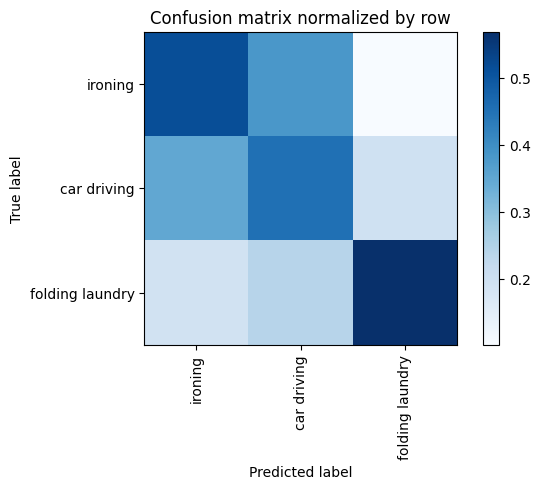

Overall accuracy: 0.521

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.764      0.516      0.616      0.608       2334|	 car driving: 0.382,	folding laundry: 0.102,	
folding laundry       0.617      0.569      0.592      0.253        973|	 car driving: 0.240,	ironing: 0.190,	
    car driving       0.177      0.454      0.255      0.139        533|	 ironing: 0.349,	folding laundry: 0.197,	

----------------------------------------------------------------------------------------------------
    avg / total       0.646      0.521      0.560        1.0       3840|	      



In [55]:
test_metrics, _, _ = eval_step1(imu_model, test_dl, unseen_action_ft, unseen_action_label, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes,  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'], neighs=10)
